# Parcours Data Analyst - V1
# Projet n°7 : Effectuez une prédiction de revenus
**Auteur** : Benoit ANTIGNY <br />
**Mentor** : Zied JEMAI <br />

**Date de création** : 12/07/2021 <br />
**Dernière mise à jour** : 07/10/2021

<hr style="border:3px solid dark"> </hr>

**Objectifs du projet** : Créer un modèle capable de prédire la  classe de revenu potentiel d'une personne. <br />
$\large\hookrightarrow$ Régression linéaire à 3 variables :
- classe de revenu des parents;
- produit intérieur brut (en PPA) du pays de résidence du prospect;
- indice de Gini des revenus du pays de résidence.

**<font size="5"> Accès rapide aux sections </font>**

[1. Paramètres et déclaration des fonctions](#set_up) <br>
[2. Analyse exploratoire et correctifs](#exploration) <br>
[3. Diversité de l'échantillon](#diversity) <br>
[4. Classe de revenu des parents](#parent_class) <br>
[5. Tests statistiques](#stats)

<a id='set_up'></a>

## Paramètres et déclaration des fonctions

<hr style="border:1px solid dark"> </hr>

### Importations des librairies

In [1]:
%matplotlib inline
%load_ext pycodestyle_magic

import time


import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import plotly.express as px

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.stats as stats

import seaborn as sns

from sklearn import decomposition, preprocessing
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import patsy


from plt_params import plt_params
from functions import *


from IPython.core.display import display, Markdown, Latex, HTML
HTML("""<style> {text-align: center; vertical-align: middle} </style>""")

### Python linting : pep8 

Permet d'alerter sur les problèmes de forme du code

In [2]:
%pycodestyle_on

### Paramètres graphiques

**Options d'affichage de pandas**

In [3]:
pd.set_option('display.max_row', 25)
pd.set_option('display.max_column', 12)

**Palettes de couleur**

In [4]:
tableau10 = ['#1f77b4', '#ff7f0e', '#d62728', '#17becf', '#2ca02c',
             '#bcbd22', '#9467bd', '#e377c2', '#8c564b', '#7f7f7f']

matplt10 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

**Personnalisation des parmètres d'affichage par défaut**

In [5]:
plt_params()

In [6]:
%pycodestyle_off  # pour éviter une erreur pycodestyle

# boxplot props
props = {
    "boxprops":{"edgecolor":"black"},
    "meanprops":{"marker":"o", "markeredgecolor":"black", "markerfacecolor":"firebrick"},
    "medianprops":{"color":"black"},
    "whiskerprops":{"color":"black"},
    "capprops":{"color":"black"},
    "flierprops":{"marker":"o", "markerfacecolor":"white"}
}

%pycodestyle_on

### Fichiers sources

**Importation du jeu de données**

In [7]:
dataset = pd.read_csv('fichiers_P7/data_projet7.csv')
population = pd.read_csv('fichiers_p7/population.csv')
gini_index = pd.read_csv('fichiers_P7/gini_index.csv', header=2)
metadata = pd.read_csv('fichiers_P7/metadata.csv')
elasticity = pd.read_csv('fichiers_P7/elasticity.csv')

### Dossier de sauvegarde

In [8]:
save = r'C:\Users\Benoit\Desktop\OpenClassrooms_Formation\P7\figure'

<a id='exploration'></a>

## Analyse exploratoire et correctifs

<hr style="border:1px solid dark"> </hr>

### PPP (Purchasing Power Parity)

En français :
**PPA (Parité de Pouvoir d'Achat)**

Le produit intérieur brut (PIB) est l'indicateur économique qui permet de quantifier la valeur totale de la « production de richesse » annuelle effectuée par les agents économiques (ménages, entreprises, administrations publiques) résidant à l'intérieur d'un territoire.

La parité de pouvoir d'achat (PPA) (on parle de valeurs mesurées en parité de pouvoir d'achat) est une méthode utilisée en économie pour établir une comparaison, entre pays, du pouvoir d'achat des devises nationales, ce qu’une simple utilisation des taux de change ne permet pas de faire. 
La PPA permet de mesurer combien une devise permet d’acheter de biens et services dans chacune des zones que l’on compare.
Les économistes forment un « panier » normalisé de biens et de services, dont le contenu peut être sujet à discussion.

Le PIB PPA permet donc de comparer le PIB entre plusieurs pays (dans une même unité) en se basant sur ce panier normalisé.

La variable "income" est également exprimée dans cette même unité ce qui permet de comparé les revenus d'un pays à un autre.

### Description du jeu de données initial

- **Taille** : 11599 lignes x 6 colonnes
- **Types de variables** : 2 variables quantitatives (income + gdpppp), 4 variables qualitatives
- **Valeurs manquantes** : 200 valeurs manquantes pour la variable gdpppp (2 pays différents) + quantile 41 absent pour la Lituanie (LTU)<br />
<br />
- **Années des données** : 2004, 2006, 2007, 2008, 2009, 2010, 2011
- **Nombre de pays présents** : 116
- **Proportion de la population couverte** : 91.8 %

Le jeu de données est échantillonnés par centiles. Des avantages d'un tel échantillonnage sont décrits sur cette page :
- https://fr.wikipedia.org/wiki/Quantile

In [9]:
data = dataset.copy()
pop = population.copy()
gini = gini_index.copy()
meta = metadata.copy()
coef = elasticity.copy()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,"728,89795",7297
1,ALB,2008,2,100,"916,66235",7297
2,ALB,2008,3,100,"1010,916",7297
3,ALB,2008,4,100,"1086,9078",7297
4,ALB,2008,5,100,"1132,6997",7297


Nombre de lignes : 11599
Nombre de colonnes : 6 

Nombre de variables de type object : 3
Nombre de variables de type int64 : 3
 
Pourcentage de valeurs manquantes par variable
country         0.000000
year_survey     0.000000
quantile        0.000000
nb_quantiles    0.000000
income          0.000000
gdpppp          0.017243
dtype: float64


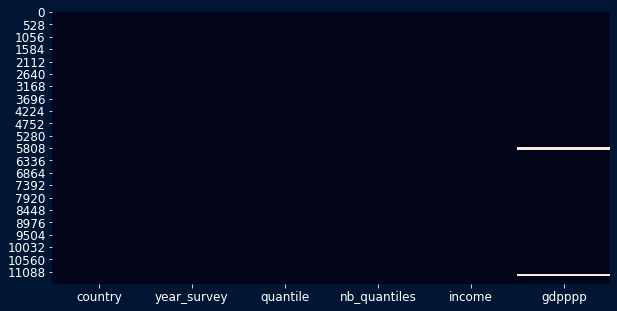

Année des données : [2004, 2006, 2007, 2008, 2009, 2010, 2011]
Nombre de pays : 116


In [10]:
years, countries = exploration_forme(data)

Certaines données numériques sont considérées comme des objets. Il faut donc les convertir avant de pouvoir obtenir les premières valeurs statistiques pour chaque grandeur pertinente.

In [11]:
# Conversion str --> float
data['income'] = data['income'].str.replace(',', '.').astype(float)
data['gdpppp'] = data['gdpppp'].str.replace(',', '.').astype(float)

#### Description statistique

In [12]:
data.describe()

,year_survey,quantile,nb_quantiles,income,gdpppp
count,11599.000000,11599.000000,11599.0,11599.000000,1.139900e+04
mean,2007.982757,50.500819,100.0,6069.224260,5.022128e+04
std,0.909633,28.868424,0.0,9414.185972,4.000688e+05
min,2004.000000,1.000000,100.0,16.719418,3.031931e+02
25%,2008.000000,25.500000,100.0,900.685515,2.576000e+03
50%,2008.000000,51.000000,100.0,2403.244900,7.560000e+03
75%,2008.000000,75.500000,100.0,7515.420900,1.877300e+04
max,2011.000000,100.000000,100.0,176928.550000,4.300332e+06


Il est déjà possible à ce stade de voir qu'il va falloir corriger quelques problèmes avec ces données.

- un quantile manquant : 11599 au lieu de 11600 (pour avoir 100 par pays)
- le maximum du gdpppp est deux ordres de grandeur plus élevé que la moyenne (elle-même plus élevé que le 3ème quartile)

#### Répartition des pays par année

In [13]:
for year in years:
    nb_countries = data[data['year_survey'] == year]['country'].unique()
    print('Année :', year, '; Nombre de pays :', len(nb_countries))
    print(nb_countries, '\n')

Année : 2004 ; Nombre de pays : 1
['SYR'] 

Année : 2006 ; Nombre de pays : 5
['GHA' 'PHL' 'THA' 'VEN' 'VNM'] 

Année : 2007 ; Nombre de pays : 15
['BIH' 'BTN' 'CHN' 'CMR' 'GIN' 'IND' 'KEN' 'LAO' 'LBR' 'LKA' 'MAR' 'MNG'
 'NER' 'TLS' 'TZA'] 

Année : 2008 ; Nombre de pays : 76
['ALB' 'ARG' 'ARM' 'AUT' 'AZE' 'BEL' 'BGR' 'BLR' 'BOL' 'BRA' 'CAF' 'CAN'
 'CIV' 'COL' 'CRI' 'CYP' 'CZE' 'DEU' 'DNK' 'DOM' 'ECU' 'ESP' 'EST' 'FIN'
 'FJI' 'FRA' 'GBR' 'GEO' 'GRC' 'HND' 'HRV' 'HUN' 'IRL' 'IRN' 'IRQ' 'ISL'
 'ISR' 'ITA' 'JOR' 'JPN' 'KAZ' 'KGZ' 'KHM' 'KOR' 'XKX' 'LTU' 'LUX' 'LVA'
 'MDA' 'MEX' 'MKD' 'MNE' 'MOZ' 'MRT' 'NLD' 'NOR' 'PAK' 'PER' 'POL' 'PRT'
 'PRY' 'ROU' 'RUS' 'SLV' 'SRB' 'SVK' 'SVN' 'SWE' 'TUR' 'TWN' 'UKR' 'URY'
 'USA' 'YEM' 'ZAF' 'COD'] 

Année : 2009 ; Nombre de pays : 12
['BFA' 'CHL' 'EGY' 'IDN' 'MYS' 'NIC' 'PAN' 'SDN' 'SWZ' 'TJK' 'UGA' 'PSE'] 

Année : 2010 ; Nombre de pays : 6
['BGD' 'MDG' 'MLI' 'MWI' 'NGA' 'NPL'] 

Année : 2011 ; Nombre de pays : 1
['GTM'] 



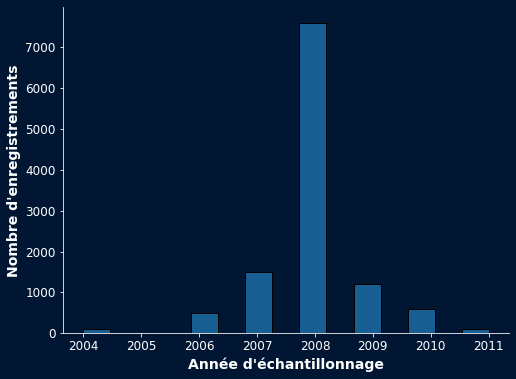

In [14]:
plt.figure(figsize=(8, 6))

sns.histplot(data=data, x='year_survey')

sns.despine()

plt.xticks(ha='center')
plt.xlabel("Année d'échantillonnage")
plt.ylabel("Nombre d'enregistrements")

plt.savefig(save + r'\01_hist_years', bbox_inches='tight')

plt.show()

La majorité des données ont été récupéré pour l'année 2008 suivi par 2007, 2009, 2010, 2006, 2011 et 2004.

#### Correction du jeu de données

Nous remarquons qu'il manque des valeurs pour la variable **gdpppp**. Nous allons commencés par identifier les pays concernés pour rechercher une valeur à leur imputer par la suite.

In [15]:
# Pays correspondants aux valeurs manquantes
data[data['gdpppp'].isna()]['country'].unique()

array(['XKX', 'PSE'], dtype=object)

Pays dont la valeur **gdpppp** n'est pas renseignée dans le jeu de données : 

- XKX = Kosovo
- PSE = Palestine (ou "West Bank and Gaza" dans la base de données WDI)

Pour choisir les valeurs à imputer, nous allons comparer les valeurs disponibles dans notre dataset et les comparer à celles de la WDI. Si plusieurs valeurs sont proches (du même ordre) pour les pays sélectionnés (choisis arbitrairement), nous récupérons celles qui nous manques dans ce même dataset.

Ainsi, les valeurs suivantes seront utilisées pour l'imputation :

- XKX : 7249.4
- PSE : 3708.7

**Imputation gdpppp**

In [16]:
# Kosovo
index_XKX = data[data['country'] == 'XKX'].index
data.loc[index_XKX, 'gdpppp'] = 7249.4

In [17]:
# Palestine
index_PSE = data[data['country'] == 'PSE'].index
data.loc[index_PSE, 'gdpppp'] = 3708.7

**Quantile manquant**

Le jeu de données étant composé de 116 pays, chacun comptabilisant 100 quantiles nous devrions avoir 11 600 lignes. <br />
Le dataframe contient ici 11 599 lignes ce qui signifie qu'un pays n'a que 99 sur les 100 quantiles.

In [18]:
# Pays au quantile manquant
[country for country in list(data['country'].unique())
 if data['country'].value_counts()[country] != 100]

['LTU']

In [19]:
# Identification du quantile manquant
[i + 1 for i in range(100)
 if i + 1 not in list(data[data['country'] == 'LTU']['quantile'])]

[41]

In [20]:
data[data['country'] == 'LTU'].loc[6239:6241, :]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6239,LTU,2008,40,100,4868.4507,17571.0
6240,LTU,2008,42,100,4895.8306,17571.0
6241,LTU,2008,43,100,4950.6380,17571.0


Le 41ème quantile de la Lituanie (LTU) est absent du jeu de données. Nous allons donc l'ajouter en prenant la moyenne arithmértique des deux quantiles adjacents.

**Imputation du quantile manquant**

In [21]:
# Localisation du quantile précédent
index_40 = data[(data['country'] == 'LTU') & (data['quantile'] == 40)].index[0]

# Ajout d'une ligne
data = data.append(data.iloc[index_40])

# Modification du numéro du quantile ajouté, trie
# et imputation de la valeur "income"
for i, col in enumerate(data.columns):
    if col == 'quantile':
        data.iloc[-1, i] = 41
        data = data.sort_values(by=['country', 'quantile'])
        data = data.reset_index(drop=True)
    if col == 'income':
        data.iat[index_40 + 1, i] = (data.iat[index_40, i]
                                     + data.iat[index_40 + 2, i]) / 2

**Recherche de valeurs extrêmes**

Maintenant que le jeu de données est complété, nous allons vérifier l'éventuelle présence de valeurs extrêmes pour la variable **gdpppp**.

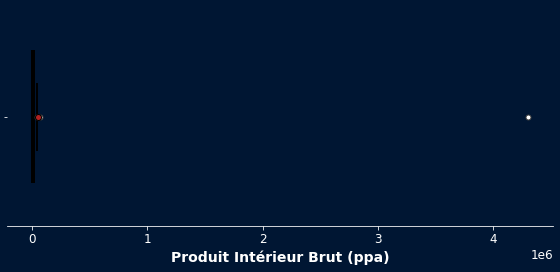

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.boxplot(data=data.drop_duplicates('country'),
            x='gdpppp',
            palette=tableau10,
            width=0.6,
            linewidth=2.,
            showmeans=True,
            showfliers=True,
            **props)

# Modifications des axes
sns.despine(left=True)
plt.xlabel('Produit Intérieur Brut (ppa)')
plt.tight_layout()

plt.savefig(save + r'\02_box_gdpppp_extreme', bbox_inches='tight')

plt.show()

La boîte à moustaches ci-dessus montre bien la présence d'au moins une valeur extrême.

In [23]:
data[data['gdpppp'] > 1e+6].drop_duplicates('country')

,country,year_survey,quantile,nb_quantiles,income,gdpppp
3300,FJI,2008,1,100,308.17334,4300332.0


La valeur pour les Fidji semble aberrante en comparaison avec les autres pays. 

Après une vérification dans la base de données WDI, la valeur trouvée pour l'année 2008 sera imputée en remplacement :

- FJI : 7777.7

In [24]:
# Fidji
index_fji = data[data['country'] == 'FJI'].index
data.loc[index_fji, 'gdpppp'] = 7777.7

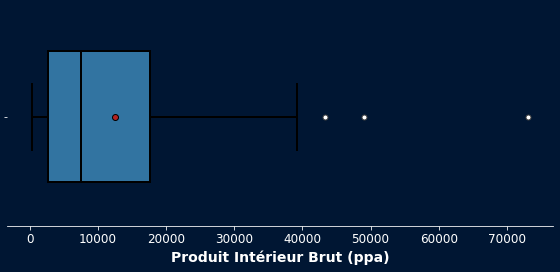

In [25]:
%pycodestyle_off # Issue with pycodestyle

fig, ax = plt.subplots(figsize=(8, 4))

sns.boxplot(data=data.drop_duplicates('country'),
            x='gdpppp',
            palette=tableau10,
            width=0.6,
            linewidth=2.,
            showmeans=True,
            showfliers=True,
            **props)

# Modifications des axes
sns.despine(left=True)
plt.xlabel('Produit Intérieur Brut (ppa)')
plt.tight_layout()

plt.savefig(save + r'\03_box_gdpppp', bbox_inches='tight')

plt.show()

%pycodestyle_on

In [26]:
# Valeurs hors écart inter-quartiles
data[data['gdpppp'] > 4e+4].drop_duplicates('country')

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6300,LUX,2008,1,100,5780.8374,73127.0
8100,NOR,2008,1,100,3520.2615,49070.0
11000,USA,2008,1,100,663.4761,43261.0


En corrigeant la valeur des Fidji, le graphique est lisible et les 3 valeurs hors écarts inter-quartiles sont probables en tenant compte de la situation économique des pays concernés.

### Proportion de la population étudiée

Afin d'avoir une idée de la portée de l'étude en terme de population, le pourcentage représenté par l'échantillon étudié est calculé dans cette section.

La grande majorité des données étant disponibles pour l'année 2008, nous utiliserons la population de l'année 2008 de chaque pays pour estimer la portée de l'étude. De plus, la population n'étant pas utile pour la suite, une estimation à 2 ou 3 ans près est amplement suffisante.

**Nettoyage de la table**

In [27]:
# Suppression des NaN
pop = pop.dropna()

# Filtrage des colonnes à conserver
pop = pop[['Country Code', '2008 [YR2008]']]

# Noms des colonnes
pop = pop.rename(columns={'Country Code': 'code_iso3',
                          '2008 [YR2008]': 'population'})

**Pourcentage de la population mondiale**

In [28]:
# Population mondiale (2008)
pop_world = pop[pop['code_iso3'] == 'WLD']['population'].astype(np.int64)
pop_world = pop_world.reset_index(drop=True)[0]

In [29]:
# Population des pays étudiés
pop = pop[pop['code_iso3'].isin(countries)]

# Pays étudiés dont la population n'est pas disponible
set(countries) - set(pop['code_iso3'])

{'TWN'}

La population de Taiwan n'est pas renseignée dans la base de donnée de la WDI.

Une recherche rapide permet de récupérer une valeur pour l'année 2008 :
- Taiwan : 23 037 000 (https://countryeconomy.com/demography/population/taiwan)

In [30]:
# Imputation de la population de Taiwan
pop = pop.append({'code_iso3': 'TWN', 'population': 23037000},
                 ignore_index=True)

# Conversion str --> int
pop['population'] = pop['population'].astype(np.int64)

# Calcul
reach = pop['population'].sum() / pop_world

print(f'Pourcentage de la population mondiale étudiée : {reach*100:.1f} %')

Pourcentage de la population mondiale étudiée : 91.8 %


Notre avons ainsi une bonne couverture mondiale pour réaliser cette étude sur les revenus.

### Indices de Gini $G_j$

Cet indice permet d'avoir une mesure de l'inégalité d'une grandeur au sein d'une population donnée. Dans notre cas, il nous servira pour avoir une idée de la répartition des revenus pour chaque pays.

Pour visualiser l'évolution de cet indice pour différents pays nous utilisons des données supplémentaires récupérés dans la base de la WDI. Cette table étant creuse, nous la préparons de la manière suivante :
- Réduction des données en supprimant les variables inutiles et les pays qui ne sont pas présent dans notre étude;
- Limitation à partir de 1990 (peu de données avant 1990);
- Suppression des lignes ne contenant que des NaN;
- Imputation des valeurs en prenant la valeur précédente la plus proche
- Suppression des colonnes remplies de NaN (années les plus anciennes)
- Imputation des valeurs restantes en prenant la valeur la plus ancienne (uniquement utile pour l'évolution temporelle de l'indice de Gini)

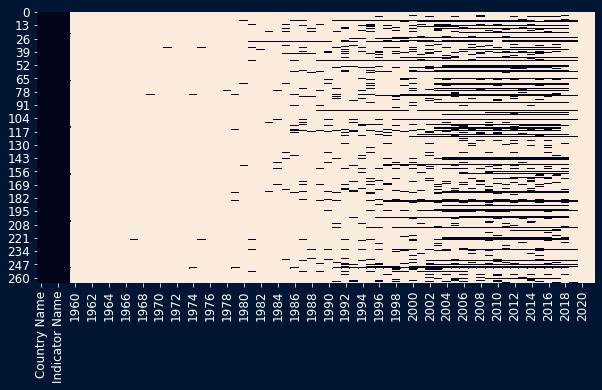

In [31]:
# Valeurs disponibles
plt.figure(figsize=(10, 5))
sns.heatmap(gini.isna(), cbar=False)

plt.savefig(save + r'\gini_table', bbox_inches='tight')

plt.show()

Nous remarquons que nous avons très peu de données avant les années 1990. Nous pouvons tronquer les années antérieures pour l'affichage de la variation de l'indice de Gini puisque nous n'aurions que peu de variations à observer.

In [32]:
# Suppression des colonnes inutiles
gini = gini.drop(columns=['Country Name', 'Indicator Name',
                          'Indicator Code', 'Unnamed: 65'])
gini = gini.rename(columns={'Country Code': 'country'})

# Pays en communs avec le jeu de données principal
gini = gini[gini['country'].isin(countries)]

# Limitation à partir de 1990
_ = gini['country']
gini = gini.loc[:, '1990':]
gini.insert(0, 'country', _)

# Suppression des lignes ne comportant aucune valeur non nulle
gini = gini[gini.index.isin(gini.iloc[:, 4:].dropna(axis=0, how='all').index)]

# Remplissage des NaN de gauche à droite avec la dernière valeur non nulle
gini.iloc[:, 1:] = gini.iloc[:, 1:].fillna(method='ffill', axis=1)

# Suppression des colonnes vides
gini = gini.dropna(axis=1, how='all')

# Remplissage des NaN de droite à gauche avec la dernière valeur non nulle
gini.iloc[:, 1:] = gini.iloc[:, 1:].fillna(method='bfill', axis=1)

# Visualisation du résultat
gini = gini.reset_index(drop=True)
gini.head(5)

,country,1990,1991,1992,1993,1994,...,2015,2016,2017,2018,2019,2020
0,ALB,27.0,27.0,27.0,27.0,27.0,...,32.9,33.7,33.2,33.2,33.2,33.2
1,ARG,46.8,46.8,45.5,44.9,45.9,...,41.6,42.0,41.1,41.3,42.9,42.9
2,ARM,36.2,36.2,36.2,36.2,36.2,...,32.4,32.5,33.6,34.4,29.9,29.9
3,AUT,31.3,31.3,31.3,31.3,31.3,...,30.5,30.8,29.7,30.8,30.8,30.8
4,AZE,34.7,34.7,34.7,34.7,34.7,...,26.6,26.6,26.6,26.6,26.6,26.6


Nous avons bien les indices de Gini des pays de notre étude à l'exception de 4 d'entre eux. Ceux-ci ne pourront pas donc pas servir pour illustrer la diversité de notre jeu de données.

Pour la régression linéaire, nous utiliserons les indices de Gini calculés à partir des données de notre jeu de départ.

**Calcul des indices de Gini**

In [33]:
# Création de la colonne Gini dans le dataframe principal
data['gini'] = 0

for c in data[data['gini'] == 0]['country'].unique():

    quantiles = data[data['country'] == c]['income']
    n = len(quantiles)

    lorenz = (np.cumsum(np.sort(quantiles)) / quantiles.sum())
    lorenz = np.append([0], lorenz)

    AUC = (lorenz.sum() - lorenz[-1]/2 - lorenz[0]/2) / n
    S = 0.5 - AUC
    gini_index = 2*S

    data.loc[data[data['country'] == c].index.values, 'gini'] = gini_index*100

Les indices de Gini sont tous ajoutés dans notre jeu de données. Avant de commencer l'étude nous allons récupérer quelques métadonnées de la WDI pour nous aider à la lecture et à l'interprétation de nos résultats.

### Indicateurs géo-économiques

Pour faciliter la lecture des tables et l'analyse des résultarts nous récupérons des éléments supplémentaires :

- le nom des pays associé;
- la région du monde; 
- le groupe de revenu (low, lower middle, upper middle, high).

In [34]:
# Ajout des classes de revenus et du nom de chaque pays
data = data.merge(meta, how='left', left_on='country', right_on='Code')
data = data.drop(['Code', 'nb_quantiles'], axis=1)

# Modification des noms des colonnes et réarrangement pour faciliter la lecture
data = data.rename(columns={'country': 'code_iso3',
                            'Income Group': 'income_group',
                            'Table Name': 'country',
                            'Region': 'region'})

data = data[['country', 'code_iso3', 'region',
             'year_survey', 'income_group', 'quantile',
             'income', 'gdpppp', 'gini']]

# Affichage
data.head(5)

,country,code_iso3,region,year_survey,income_group,quantile,income,gdpppp,gini
0,Albania,ALB,Europe & Central Asia,2008,Upper middle income,1,728.89795,7297.0,30.462429
1,Albania,ALB,Europe & Central Asia,2008,Upper middle income,2,916.66235,7297.0,30.462429
2,Albania,ALB,Europe & Central Asia,2008,Upper middle income,3,1010.91600,7297.0,30.462429
3,Albania,ALB,Europe & Central Asia,2008,Upper middle income,4,1086.90780,7297.0,30.462429
4,Albania,ALB,Europe & Central Asia,2008,Upper middle income,5,1132.69970,7297.0,30.462429


Nous vérifions comme pour les autres tables les valeurs manquantes.

In [35]:
# Affichage des lignes avec au moins une valeur manquante
data[data.isna().any(axis=1)].head(5)

,country,code_iso3,region,year_survey,income_group,quantile,income,gdpppp,gini
10500,NaN,TWN,NaN,2008,NaN,1,3477.1800,25342.0,31.480138
10501,NaN,TWN,NaN,2008,NaN,2,4740.2637,25342.0,31.480138
10502,NaN,TWN,NaN,2008,NaN,3,5331.3013,25342.0,31.480138
10503,NaN,TWN,NaN,2008,NaN,4,5761.6577,25342.0,31.480138
10504,NaN,TWN,NaN,2008,NaN,5,6093.2017,25342.0,31.480138


Le groupe n'est pas connu pour deux des pays de notre table. Pour les imputer, nous allons nous appuyer sur la moyenne des variables **gdpppp** et **gini** des pays des différents groupes.

In [36]:
cls_income = data.drop_duplicates('country').groupby(by='income_group').mean()
cls_income = cls_income[['gdpppp', 'gini']]
cls_income

,gdpppp,gini
income_group,,
High income,29203.823529,31.920712
Low income,1255.932014,40.965640
Lower middle income,3136.247467,38.734875
Upper middle income,8686.236224,41.846970


Nous rajoutons le nom "Taïwan" asocié au code "TWN" ainsi que la région "East Asia & Pacific".

Pour éviter des problèmes d'affichages dus à l'encodage des caractères nous modifions préventivement le nom de la "Côte d'Ivoire".

Pour les groupes de revenus Taïwan semble plutôt correspondre à la catégorie "High income" et le Vénézuela à la catégorie "Upper middle income".

In [37]:
# Ajout du nom de pays manquant
data.loc[data[data['country'].isna()].index, 'country'] = 'Taïwan'

# Ajout de la région de Taïwan
data.loc[data[data['region'].isna()].index, 'region'] = 'East Asia & Pacific'

# Modification du nom du pays pour éviter des problèmes d'affichages
data.loc[data[data['code_iso3'] == 'CIV'].index, 'country'] = "Cote d'Ivoire"

# Ajout des classes manquantes
data.loc[data[data['code_iso3'] == 'TWN'].index,
         'income_group'] = 'High income'
data.loc[data[data['code_iso3'] == 'VEN'].index,
         'income_group'] = 'Upper middle income'

data.head(5)

,country,code_iso3,region,year_survey,income_group,quantile,income,gdpppp,gini
0,Albania,ALB,Europe & Central Asia,2008,Upper middle income,1,728.89795,7297.0,30.462429
1,Albania,ALB,Europe & Central Asia,2008,Upper middle income,2,916.66235,7297.0,30.462429
2,Albania,ALB,Europe & Central Asia,2008,Upper middle income,3,1010.91600,7297.0,30.462429
3,Albania,ALB,Europe & Central Asia,2008,Upper middle income,4,1086.90780,7297.0,30.462429
4,Albania,ALB,Europe & Central Asia,2008,Upper middle income,5,1132.69970,7297.0,30.462429


In [38]:
# Liste des régions
region = list(data['region'].unique())
region

['Europe & Central Asia',
 'Latin America & Caribbean',
 'Sub-Saharan Africa',
 'South Asia',
 'North America',
 'East Asia & Pacific',
 'Middle East & North Africa']

### Coefficient d'élasticité $\rho_j$

Pour calculer la dernière valeur qu'il nous faut pour la régression linéaire, nous avons besoin du coefficient d'élasticité (ou mobilité intergénérationnelle) pour chaque pays de notre jeu de données.

**Coefficients de la World Bank**

Une partie de ses coefficients est téléchargé à partir du site de la World Bank en suivant ce lien : <br>
https://www.worldbank.org/en/topic/poverty/brief/what-is-the-global-database-on-intergenerational-mobility-gdim

Ces données sont stockées dans la table suivante que nous allons nettoyer avant d'en récupérer ce qui nous intéresse.

In [39]:
coef.head(5)

,countryname,wbcode,iso3,region,incgroup2,incgroup4,...,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,...,0.345224,NaN,NaN,NaN,NaN,0.1
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,...,0.389952,NaN,NaN,NaN,NaN,0.1
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,...,0.307687,NaN,NaN,NaN,NaN,0.1
3,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,...,0.218062,NaN,NaN,NaN,NaN,0.1
4,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,...,0.230909,NaN,NaN,NaN,NaN,0.1


Parmi les variables disponibles nous ne conserveront que le code **iso3** (code du pays) et la variable **IGEincome** (coefficient d'élasticité).

In [40]:
# Sélection des variables à conserver
coef = coef[['iso3', 'IGEincome']]

# Suppression des valeurs non renseignées
coef = coef.dropna()
coef

,iso3,IGEincome
60,ALB,0.815874
61,ALB,0.815874
62,ALB,0.815874
63,ALB,0.815874
64,ALB,0.815874
...,...,...
6481,COD,0.707703
6482,COD,0.707703
6483,COD,0.707703
6484,COD,0.707703


Comme nous avons plusieurs lignes par pays nous allons nous assurer de l'unicité du coefficient pour chaque pays (i.e. que pour un pays donné nous n'ayons qu'une seule valeur). Pour ce faire nous utilisons le test suivant :

In [41]:
# Test d'unicité des coefficients
np.all(coef.value_counts().reset_index()['iso3'].value_counts().values == 1)

True

Le test nous montre que nous avons bien pour chaque pays une unique valeur. Nous pouvons donc supprimer les doublons.

In [42]:
# Suppression des doublons
coef = coef.drop_duplicates()
print("Nombre de pays ayant un coefficient d'élasticité :", len(coef))

# Noms des variables
coef = coef.rename(columns={'iso3': 'code_iso3', 'IGEincome': 'pj'})
coef.head(5)

Nombre de pays ayant un coefficient d'élasticité : 75


,code_iso3,pj
60,ALB,0.815874
183,AUS,0.275000
243,AUT,0.245267
351,BEL,0.183176
405,BEN,0.855116


Ces coefficients sont ajoutés au jeu de données.

In [43]:
# Ajout du coefficient au jeu de données
data = data.merge(coef, how='left', on='code_iso3')

In [44]:
value = int(data['pj'].isna().value_counts()[1] / 100)
print("Nombre de pays dont le coefficient n'est pas renseigné :", value)

Nombre de pays dont le coefficient n'est pas renseigné : 50


**Coefficients par région**

Les coefficients manquants sont fournis dans l'énoncé sous forme d'un fichier **.txt** qui regroupe les pays par région et leur associe 3 coefficients :
- un coefficient de base correspondant à un scénario moyen
- un coefficient optimiste correspondant à une mobilité accrue
- un coefficient pessimite correspondant à une mobilité moindre

| Region                               | Base case | Optimistic (high mobility) | Pessimistic (low mobility) |
| :----------------------------------- | :-------: | :------------------------: | :------------------------: |
| Nordic European countries and Canada | 0.2       | 0.15                       | 0.3                        |
| Europe (except nordic countries)     | 0.4       | 0.3                        | 0.5                        |
| Australia/New Zealand/USA            | 0.4       | 0.3                        | 0.5                        |
| Asia                                 | 0.5       | 0.4                        | 0.6                        |
| Latin America/Africa                 | 0.66      | 0.5                        | 0.9                        |

Pour notre étude nous restons dans le cas moyen (Base case).

Les coefficients seront associés aux pays qui n'en ont pas encore. Ceux de la World Bank seront conservés en priorité.

In [45]:
# Liste des pays qui n'ont pas de coefficient
list(data[data['pj'].isna()]['country'].unique())

['Argentina',
 'Armenia',
 'Azerbaijan',
 'Burkina Faso',
 'Bulgaria',
 'Bhutan',
 'Central African Republic',
 "Cote d'Ivoire",
 'Cameroon',
 'Costa Rica',
 'Dominican Republic',
 'Estonia',
 'Fiji',
 'Georgia',
 'Honduras',
 'Hungary',
 'Indonesia',
 'Iran, Islamic Rep.',
 'Iraq',
 'Iceland',
 'Israel',
 'Cambodia',
 'Lao PDR',
 'Liberia',
 'Sri Lanka',
 'Lithuania',
 'Moldova',
 'Mexico',
 'Montenegro',
 'Mozambique',
 'Mauritania',
 'Niger',
 'Nicaragua',
 'Philippines',
 'Poland',
 'Paraguay',
 'West Bank and Gaza',
 'Sudan',
 'El Salvador',
 'Serbia',
 'Eswatini',
 'Syrian Arab Republic',
 'Thailand',
 'Tajikistan',
 'Turkey',
 'Ukraine',
 'Uruguay',
 'Venezuela, RB',
 'Kosovo',
 'Yemen, Rep.']

Aucun des pays de cette liste ne fait partie des cas particuliers mentionnés dans le fichier. Nous allons donc remplir le jeu de données suivant les régions de la manière suivante :

- Europe & Central Asia : 0.4
- Latin America & Caribbean : 0.66
- Sub-Saharan Africa : 0.66
- South Asia : 0.5
- North America : 0.4
- East Asia & Pacific : 0.5
- Middle East & North Africa : 0.66

In [46]:
# Dictionnaire par région
region_pj = dict(zip(data['region'].unique(),
                     [0.4, 0.66, 0.66, 0.5, 0.4, 0.5, 0.6]))
region_pj

{'Europe & Central Asia': 0.4,
 'Latin America & Caribbean': 0.66,
 'Sub-Saharan Africa': 0.66,
 'South Asia': 0.5,
 'North America': 0.4,
 'East Asia & Pacific': 0.5,
 'Middle East & North Africa': 0.6}

In [47]:
# Ajout dans la table principale
index = data[data['pj'].isna()].index
data.loc[index, 'pj'] = data.loc[index, 'region'].map(region_pj)

Nos données sont maintenant prêtes pour l'étude. Avant de commencer, nous allons illustrer la diversité des profils des différents pays.

In [48]:
del elasticity  # Libération de la mémoire

<a id='diversity'></a>

## Diversité de l'échantillon

Pour représenter la diversité des pays étudiés, une classification ascendante hiérarchique est appliquée pour nous permettre de choisir entre 5 et 10 pays selon leur profil.

### Classification hiérarchique ascendante

Les 116 pays seront regroupés en cluster à l'aide des variables suivantes :
- produit intérieur brut
- indice de gini

La population n'est pas utilisée car celle-ci serait trop déterminante pour des pays fortement peuplés comme l'Inde et la Chine.

**Préparation des données**

In [49]:
# Création du dataframe pour la classification
data_ahc = data[['country', 'code_iso3', 'income_group',
                 'gdpppp', 'gini']].drop_duplicates('country')

# Remplacement de l'index par la colonne 'country'
data_ahc = data_ahc.set_index('country')

In [50]:
# Donneés
df = data_ahc[['gdpppp', 'gini']]

# Préparation des données pour la classification
n_comp = df.shape[1]
X = df.values
names = df.index
features = df.columns

# Centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

**Classification**

In [51]:
# Clustering hiérarchique
Z = linkage(X_scaled, "ward")

In [52]:
# Nombre de groupes
n_cluster = 5

# Association du groupe aux différents pays
clusters = fcluster(Z, n_cluster, criterion='maxclust')

data_ahc['group'] = clusters
data_ahc = data_ahc.sort_values('group', ascending=True)
data_ahc['group'] = data_ahc['group'].astype(str)

**Résultats**

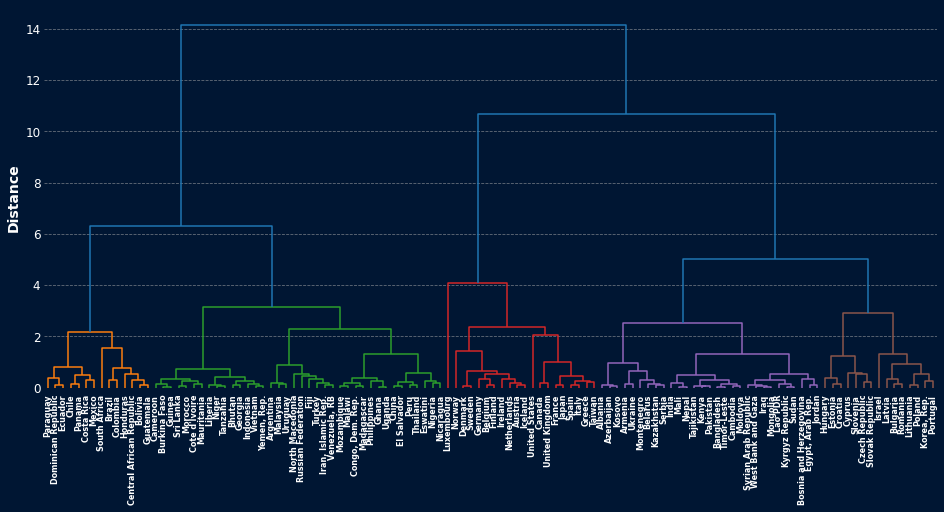

In [53]:
# Affichage du dendrogramme
# fig = plt.figure(figsize=(16, 7))

fig, ax = plt.subplots(figsize=(16, 7))

plt.ylabel('Distance', color='white')

dendrogram(Z,
           labels=names,
           orientation='top',
           leaf_font_size=10,
           color_threshold=4.5)

sns.despine(left=True, bottom=True)
plt.grid(False, axis='x')
plt.tick_params(axis='y', which='both', length=0)
plt.xticks(fontsize=8, fontweight='bold', color='white')
plt.yticks(color='white')

ax.yaxis.grid(True, linestyle='--', alpha=0.6)  # Hide the horizontal gridlines
ax.xaxis.grid(False)  # Show the vertical gridlines

plt.savefig(save + r'\04_dendrogram_cah', bbox_inches='tight')

plt.show()

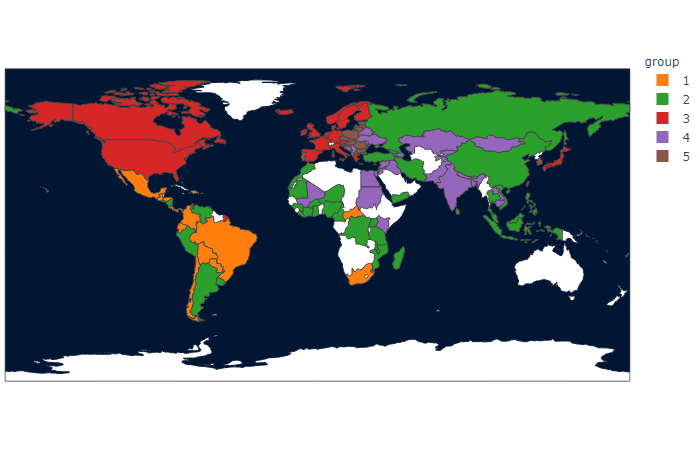

In [54]:
# Carte du monde des groupes
fig = px.choropleth(data_frame=data_ahc,
                    locations=data_ahc['code_iso3'],
                    color='group',
                    color_discrete_sequence=matplt10[1:],
                    hover_name=data_ahc.index)

fig.update_layout(autosize=False,
                  width=950,
                  height=550,
                  margin=dict(
                      l=5,
                      r=5,
                      b=50,
                      t=50,
                      pad=4),
                  )

fig.update_geos(
    resolution=110,
    showcoastlines=True, coastlinecolor='#001633',
    showland=True, landcolor='white',
    showocean=True, oceancolor='#001633',
    showlakes=False, lakecolor='Blue',
    showrivers=False, rivercolor='Blue'
)

fig.write_image(save + r'\05_map_cah.png')

fig.show(renderer='png')

Le détail des résultats nous permet de donner la tendance de chaque groupe formé par notre classification :

- groupe 1 : inégalité la plus élevée
- groupe 2 : inégalité relativement élevé et revenus faibles
- groupe 3 : revenus élevés
- groupe 4 : inégalité faible et revenus faibles
- groupe 5 : revenus relativement élevés et inégalité faible

In [55]:
# Exemple du groupe 1
data_ahc[data_ahc['group'] == '1']

,code_iso3,income_group,gdpppp,gini,group
country,,,,,
South Africa,ZAF,Upper middle income,9602.0,66.977850,1
Panama,PAN,Upper middle income,11767.0,53.191696,1
Mexico,MEX,Upper middle income,13434.0,50.798919,1
Paraguay,PRY,Upper middle income,4347.0,52.512636,1
Honduras,HND,Lower middle income,3628.0,60.166676,1
Ecuador,ECU,Upper middle income,7560.0,50.987962,1
Dominican Republic,DOM,Upper middle income,7505.0,50.252398,1
Costa Rica,CRI,Upper middle income,10374.0,49.253343,1
Colombia,COL,Upper middle income,8185.0,56.927123,1


A l'aide des résultats de la classification les pays suivants seront utilisés pour illustrer la diversité des pays en termes de distribution de revenus :
- Group 1 : Afrique du Sud (ZAF) + République Centrafricaine (CAF)
- Group 2 : Chine (CHN)
- Group 3 : Danemark (DNK) + Etats-Unis (USA)
- Group 4 : Mongolie (MNQ)
- Group 5 : Pologne (POL)

In [56]:
# Liste des pays retenus
select = ['CAF', 'CHN', 'DNK', 'MNG', 'POL', 'USA', 'ZAF']

### Distributions des revenus

Les distributions des revenus des différents pays sélectionnés sont affichés sur les graphiques suivants.

Pour le premier graphique, une échelle logarithmique est appliquée sur l'axe verticale pour une meilleur lisibilité.

**Comparaison des distributions de revenus**

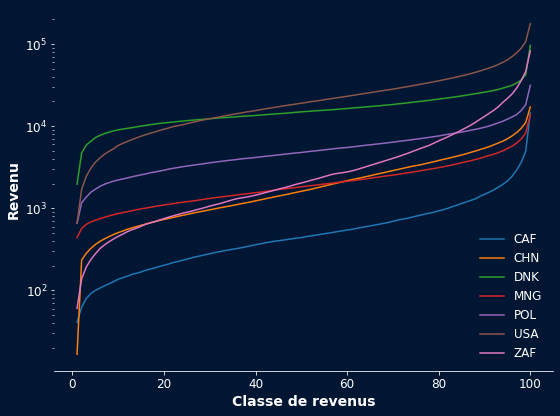

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))

for code in select:
    sns.lineplot(data=data[data['code_iso3'] == code],
                 x='quantile',
                 y='income')

# Modifications des axes
ax.set(yscale="log")

sns.despine(left=True)
plt.xlabel('Classe de revenus')
plt.ylabel('Revenu')
plt.tight_layout()
plt.legend(labels=select)

plt.savefig(save + r'\06_incomes', bbox_inches='tight')

plt.show()

Nous voyons bien la grande diversité de répartitions des revenus pour des pays plus ou moins égalitaires (différences entre le minimum et le maximum) et plus ou moins riches (ordonnées de la courbe).

**Courbes de Lorenz des distributions de revenus des pays sélectionnés**

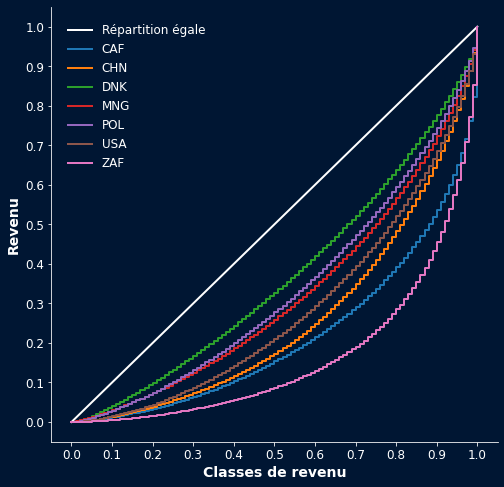

In [58]:
df = pd.DataFrame()  # inialisation du dataframe des courbes de lorenz
n = 100  # nombre de quantiles

# Calcul des courbes de Lorenz
for code in select:
    income = data.loc[data[data['code_iso3'] == code].index, 'income']

    lorenz = np.cumsum(income) / income.sum()
    lorenz = np.append([0], lorenz)  # La courbe de Lorenz commence à 0
    df.insert(df.shape[1], code, lorenz)


# Affichage des courbes
fig, ax = plt.subplots(figsize=(8, 8))

xaxis = np.linspace(0, 1, n+1)  # abscisses

# Première bissectrice
plt.plot([0, 1], [0, 1], linewidth=2, color='white', label='Répartition égale')

# Courbes de Lorenz
for code in df.keys():
    plt.plot(xaxis, df[code], drawstyle='steps-post', linewidth=2, label=code)

# Modifications des axes
sns.despine()
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xlabel('Classes de revenu')
plt.ylabel('Revenu')

# Légende
leg = plt.legend(loc='upper left', borderaxespad=1)
leg.draw_frame(False)

# Sauvegarde au format png
plt.savefig(save + r'\07_lorenz_income', bbox_inches='tight')

plt.show()

Ce graphique permet de mettre en évidence l'inégalité des revenus de la population des différents pays choisis. On remarque nettement que l'inégalité est la plus marquée pour l'Afrique du Sud (ZAF).

**Variations temporelles des indices de Gini**

Nous nous intéressons maintenant aux variations des indices de Gini pour les pays choisis. Nous filtrons la table des indices de Gini par année que nous avions préparé dans la partie précédente.

In [59]:
# Filtrage pour les pays retenus
gini_select = gini[gini['country'].isin(select)]

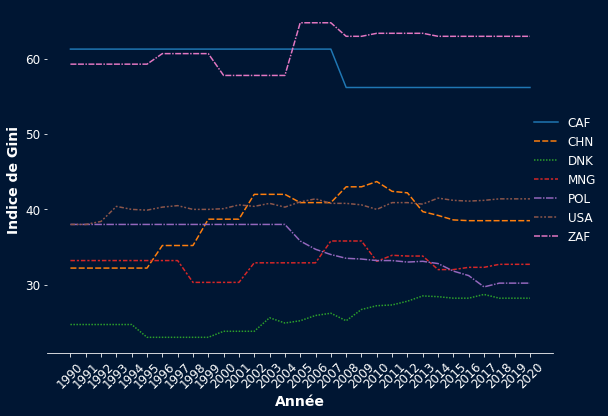

In [60]:
# Affichage des variations des indices de Gini
fig, ax = plt.subplots(figsize=(8, 6))

df = gini_select.set_index('country').transpose()
sns.lineplot(data=df)

# Modifications des axes
sns.despine(left=True)
plt.xlabel('Année')
plt.xticks(rotation=45)
plt.ylabel('Indice de Gini')
plt.tight_layout()

# Légende
# plt.legend(labels=df.columns)
leg = plt.legend(loc='center right', borderaxespad=-4)
leg.draw_frame(False)

plt.savefig(save + r'\08_variation_gini', bbox_inches='tight')

plt.show()

L'évolution de l'indice de Gini est faible pour les pays développés comme le Danemark ou les Etats-Unis. Le cas le plus notable est celui de la Chine qui croît globalement depuis le milieu des années 90 et diminue en 2010.

**Classement des pays par indice de gini**

Regardons maintenant quelques statistiques sur les indices de Gini telles que la moyenne ou les top 5 des indices les plus faibles et les plus élevés.

In [61]:
# Projection et tri des indices de Gini et des noms de pays associés
sorted_data = data[['country', 'gini']].drop_duplicates()
sorted_data = sorted_data.sort_values('gini', ascending=True)
sorted_data = sorted_data.reset_index(drop=True)
sorted_data.index += 1

In [62]:
# Moyenne de notre jeu de données
value = np.round(sorted_data['gini'].mean(), 2)
print(f'Indice de Gini moyen : {value}')

Indice de Gini moyen : 37.9


In [63]:
# Top 5 Gini faibles
print('Top 5 des pays les plus égalitaires :')
sorted_data.head(5)

Top 5 des pays les plus égalitaires :


,country,gini
1,Slovenia,23.073125
2,Slovak Republic,24.721892
3,Czech Republic,25.286391
4,Sweden,25.488746
5,Ukraine,25.513965


Les pays les plus égalitaires sont des pays d'Europe de l'Est ou de Scandinavie.

In [64]:
# Top 5 Gini élevés
print('Top 5 des pays les plus inégalitaires :')
sorted_data.tail(5)[::-1]

Top 5 des pays les plus inégalitaires :


,country,gini
116,South Africa,66.977850
115,Honduras,60.166676
114,Colombia,56.927123
113,Guatemala,56.829274
112,Central African Republic,56.173214


Les pays les plus inaglitaires sont majoritairement des pays d'Afrique ou d'amérique du Sud.

In [65]:
# Classement de la France
for idx, country in enumerate(sorted_data['country']):
    if country == 'France':
        print(f'Position de la France : {idx + 1} / {len(sorted_data)}')
        gini_FRA = sorted_data.loc[idx + 1, 'gini']
        print(f'Indice de gini de la France : {gini_FRA}')

Position de la France : 40 / 116
Indice de gini de la France : 32.909623876035674


Dans ce classement la France est située dans la moyenne haute (en considérant les indices de Gini par ordre décroissant) avec un indice de 33.

<a id='parent_class'></a>

## Classe de revenus des parents $c_{i,parent}$

Maintenant que nous avons fini d'explorer et d'illustrer la portée et la diversité de notre jeu de données, il nous reste à obtenir la troisième variable explicative pour notre modèle.

Dans cette partie nous allons donc détailler le processus de détermination de la classe de revenu des parents. Avant cela, nous allons illustrer l'effet du coefficient d'élasticité sur les revenus des enfants en connaissant celui des parents. Le lien entre les différentes grandeurs est donné par la relation suivante :

\begin{equation}
\large
ln(y_{child}) = \alpha + \rho_j ln(y_{parent}) + \epsilon
\end{equation}

$y_{\large child}$ : revenu de l'enfant
<br>
$y_{\large parent}$ : revenu du parent
<br>
$\rho_j$ : coefficient d'élasticité du pays $j$ (ou mobilité intergénérationnelle)
<br>
$\alpha$ : ordonnée à l'origine (ici sa valeur sera condirée comme nulle car nous ne nous intéressons pas aux revenus précis mais à la classe (quantile))
<br>
$\epsilon$ : terme d'erreur (suit une loi normale de moyenne 0 et d'écart-type 1)


### Illustration de l'effet du coefficient d'élasticité

Pour illustrer l'effet du coefficient d'élasticité nous allons procéder comme il suit :
- générer deux séries de valeurs de taille $n$ suivant une loi normale de moyenne 0 et d'écart-type 1 pour simuler $ln(y_{\large parent})$ et le terme d'erreur $\epsilon$;
- calculer $y_{\large parent}$ et $y_{\large child}$ avec les expressions suivantes :

\begin{equation}
\large
y_{parent} = e^{\Large (ln(y_{parent}))}
\end{equation}
\begin{equation}
\large
y_{child} = e^{\Large (\alpha + \rho_j ln(y_{parent}) + \epsilon)}
\end{equation}

$\rho_j$ est ici fixé arbitrairement pour montrer l'effet sur les probabilités conditionnelles. Par la suite, il sera déterminé pour chaque pays séparément.

- tri des valeurs par ordre croissant et association des valeurs de $y_{\large parent}$ et $y_{\large child}$ aux quantiles (pour cet exemple déciles) correspondant;
- calcul des probabilités conditionnelles et création de la matrice répertoriant tous les cas;
- affichage des distributions sous forme de barchart à barres empilées.

**Calcul des probabilités conditionnelles pour un coefficient d'elasticié proche de 0**

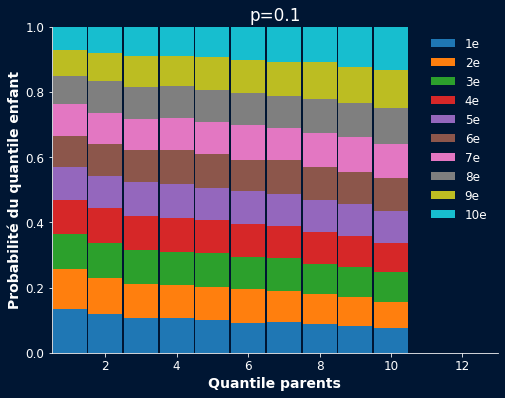


P(c_i_parent = 8 | c_i_child = 5, pj = 0.1) = 0.0985


In [66]:
pj = 0.1                 # coefficient d'élasticité du pays j
nb_quantiles = 10        # nombre de quantiles (nombre de classes de revenu)
n = 10000*nb_quantiles   # taille de l'échantillon


y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd_01 = conditional_distributions(sample, nb_quantiles)

# Cette instruction prendra du temps si nb_quantiles > 10
plot_conditional_distributions(pj, cd_01, nb_quantiles, save)

del y_child, y_parents

# Décalage des indices 0-9 --> 1-10
cd_01 = pd.DataFrame(cd_01)
cd_01.index += 1
cd_01.columns += 1

c_i_child = 5
c_i_parent = 8
p = cd_01.iloc[c_i_child - 1, c_i_parent - 1]
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}"
      .format(c_i_parent, c_i_child, pj, p))

Un coefficient proche de 0 indique une forte mobilité intergénérationnelle. Quelque soit la classe des parents, un enfant à environ les mêmes chances d'avoir des revenus faibles, intermédiaires ou élevés.

**Calcul des probabilités conditionnelles pour un coefficient d'elasticié proche de 1**

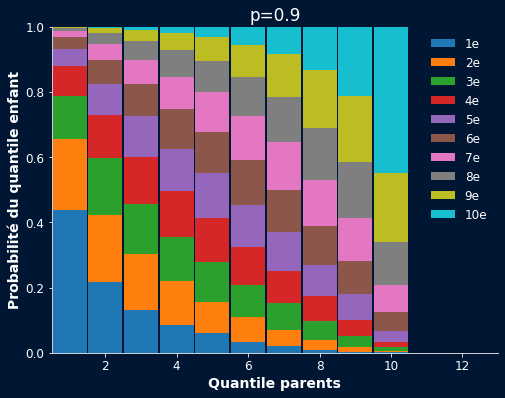


P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.0966


In [67]:
pj = 0.9                 # coefficient d'élasticité du pays j
nb_quantiles = 10        # nombre de quantiles (nombre de classes de revenu)
n = 10000*nb_quantiles   # taille de l'échantillon


y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd_09 = conditional_distributions(sample, nb_quantiles)
del sample  # Libération de l'espace mémoire

# Cette instruction prendra du temps si nb_quantiles > 10
plot_conditional_distributions(pj, cd_09, nb_quantiles, save)

del y_child, y_parents

# Décalage des indices 0-9 --> 1-10
cd_09 = pd.DataFrame(cd_09)
cd_09.index += 1
cd_09.columns += 1

c_i_child = 5
c_i_parent = 8
p = cd_09.iloc[c_i_child - 1, c_i_parent - 1]
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}"
      .format(c_i_parent, c_i_child, pj, p))

Un coeffecient proche de 1 indique une faible mobilité intergénérationnelle. Un enfant dont les parents ont des revenus élevés aura une forte probabilité d'avoir des revenus élevés et une probabilité quasi-nulle d'avoir des revenus faibles.

**Visualisation de la table des probabilités conditionnelles**

Cette table reprend les valeurs utilisés pour le graphique précédent : 

- 1 ligne correspond à une classe enfant
- 1 colonne correspond à une classe parent

Pour lire la probabilité conditionnelle dans la table suivante, il faut repérer la colonne correspondant à la classe parent et la ligne correspondant à la casse enfant.

Détail des probabilités conditionnelles dans le cas $\rho_j$ = 0.9 :

In [68]:
# Fonction permettant de mettre en avant la valeur mentionnée
def style_specific_cell(x):

    color = 'background-color: royalblue'
    df = pd.DataFrame('', index=x.index, columns=x.columns)
    df.iloc[4, 7] = color  # child = 5, parent = 8
    return df


# Affichage de la table
cd_09.style.apply(style_specific_cell, axis=None)

,1,2,3,4,5,6,7,8,9,10
1,0.436900,0.217200,0.132300,0.085500,0.059200,0.034300,0.021000,0.009000,0.003500,0.001100
2,0.217500,0.206700,0.170200,0.133400,0.097100,0.075300,0.050100,0.030900,0.014100,0.004700
3,0.134000,0.173400,0.154100,0.137300,0.123600,0.097800,0.080300,0.056400,0.032400,0.010700
4,0.091000,0.131200,0.143600,0.139200,0.134700,0.116700,0.100200,0.077600,0.049400,0.016400
5,0.053300,0.095800,0.126100,0.129800,0.135400,0.129600,0.120200,0.096600,0.080100,0.033100
6,0.034700,0.073900,0.099100,0.122800,0.128300,0.136300,0.127800,0.118800,0.100500,0.057800
7,0.018600,0.049900,0.073600,0.096900,0.120400,0.137200,0.147400,0.141600,0.131800,0.082600
8,0.009300,0.031400,0.056500,0.084500,0.096100,0.117600,0.138700,0.159700,0.174000,0.132200
9,0.004000,0.016800,0.033600,0.052200,0.072600,0.099500,0.130900,0.176400,0.200700,0.213300
10,0.000700,0.003700,0.010900,0.018400,0.032600,0.055700,0.083400,0.133000,0.213500,0.448100


La cellule colorée correspond au cas mentionné sous le graphique précédent ($c_{i, child} = 5, c_{i, parent} = 8, \rho_j = 0.9$).

### Association de la classe de revenus des parents

A cette étape, nous avons tous les éléments pour déterminer la classe de revenus des parents. Nous allons procéder de la manière suivante :

- suppression des colonnes inutles de notre jeu de données;
- duplication des individus (x 500);
- génération du terme d'erreur pour chaque individu;
- calcul du revenu des parents $y_{\large parent}$ avec l'expression suivante :

\begin{equation}
\large
y_{parent} = e^{(\Large\frac{ln(y_{child}) - (\alpha + \epsilon)}{\rho_j})}
\end{equation}

- tri des valeurs par pays et $y_{\large parent}$
- détermination des centiles $c_{\large i,parent}$

**Création de l'échantillon**

In [69]:
# Suppression des colonnes inutiles
data = data.drop(columns={'region', 'year_survey', 'income_group'}, axis=1)
data = data.rename(columns={'income': 'y_child', 'quantile': 'c_i_child'})

# Série contenant le nombre de répétitions de chaque individu
data['repeat'] = 500

# Duplication des individus
repeat_list = pd.Series(data['repeat'])
data = data.apply(np.repeat, repeats=(repeat_list))
data = data.drop('repeat', axis=1)
del repeat_list  # Libération de l'espace mémoire

Nous avons un échantillon de 5 800 000 individus :

- 116 pays
- 50 000 individus par pays
- 5 800 000 indivus au total

Il nous faut générer un terme d'erreur pour chaque individus, calculer le revenu des parents associé et trier les données par pays et par revenu des parents $y_{\large parent}$ dans l'ordre croissant.

In [70]:
n_ind = data.shape[0]  # Nombre d'individus

# Terme d'erreur epsilon
data['epsilon'] = st.norm(0, 1).rvs(size=n_ind)

# Revenu des parents
data['y_parent'] = np.exp((np.log(data['y_child']) - data['epsilon']) /
                          data['pj'])

# Tri des valeurs
data = data.sort_values(by=['code_iso3', 'y_parent'])
data = data.reset_index(drop=True)

Nous avons maintenant notre jeu de données trié. Il nous faut calculer les quantiles pour un pays et dupliquer le résultat par le nombre de pays. Le jeu de données étant trié, l'association revenue/quantile sera faite automatiquement.

In [71]:
nb_q = 100  # Nb de quantiles
n = int(n_ind / len(data['code_iso3'].unique()))  # Nb individus par pays
n_c = len(data['code_iso3'].unique())  # Nb de pays

# Série contenant les quantiles
quantiles = np.round(np.arange(1, nb_q + 1, nb_q / n) - 0.5 + 1. / n)
quantiles = pd.Series(quantiles)

# Duplication de la série par le nombre de pays
quantiles = pd.concat([quantiles]*n_c, ignore_index=True)

# Ajout des quantiles au jeu de données
data['c_i_parent'] = quantiles.apply(int)
del quantiles  # Libération de la mémoire

In [72]:
# Table d'association des pays avec leur code ISO 3
countries = data[['country', 'code_iso3']].drop_duplicates()
countries = countries.reset_index(drop=True)
countries.head(5)

,country,code_iso3
0,Albania,ALB
1,Argentina,ARG
2,Armenia,ARM
3,Austria,AUT
4,Azerbaijan,AZE


In [73]:
# Suppression des colones inutiles
data = data.drop(columns={'country', 'c_i_child', 'pj', 'epsilon', 'y_parent'})
data.head(5)

,code_iso3,y_child,gdpppp,gini,c_i_parent
0,ALB,1351.31230,7297.0,30.462429,1
1,ALB,916.66235,7297.0,30.462429,1
2,ALB,1351.31230,7297.0,30.462429,1
3,ALB,728.89795,7297.0,30.462429,1
4,ALB,916.66235,7297.0,30.462429,1


Le dataset contient les 3 grandeurs souhaitées pour la régression linéaire. La dernière partie de ce projet consistera à expliquer le lien entre les revenus $y_{\large child}$ et les différentes variables dont nous disposons.

<a id='stats'></a>

## Test statistiques

Nous souhaitons maintenant :
- nous assurer que les income sont significativement différents (d'un point de vue statistique) entre les différents pays;
- savoir quelles variables permettent d'expliquer la distribution des revenus $y_{\large child}$.

Le premier point sera testé par une **ANOVA** (**AN**alysis **O**f **VA**riance). La normalité sera testée sur l'ensemble du jeu de données. sur un sous-ensemble comprenant les pays choisis précédemment pour illustrer la diversité de l'échantillon.

La méthodologie suivie pour cette partie est en grande partie inspirée des sources suivantes :
- https://www.pythonfordatascience.org/anova-python/
- https://www.pythonfordatascience.org/linear-regression-python/


### ANOVA

L'ANOVA permet, si les hypothèses sont vérifiées, de vérifier si les moyennes des groupes proviennent d'une même population ($\mu_1 = \mu_2 = ... = \mu_n$ pour un échantillon contenant n groupes). Ici nous souhaitons vérifier si le pays d'origine à un impact sur le revenu moyen.

**Formulation du test** :

\begin{equation}
\left\{
    \begin{array}{ll}
        H_0 : \mu_1 = \mu_2 = \text{ ... } = \mu_n ~~~~ \text{(égalité des moyennes)} \\
        H_1 : \mu_1 \neq \mu_2 \neq \text{ ... } \neq \mu_n ~~~~ \text{(moyennes non équivalentes)}
    \end{array}
\right.
\end{equation}

Rejet de l'hypothèse nulle ($H_0$) si la p-value est inférieure à 0.05 ($\alpha = 5$%).

**Hypothèses** à vérifier pour effectuer l'ANOVA :
- indépendance des échantillons (groupes);
- distribution normale de la variable continue (variable endogène);
- variances égales entre les différents groupes (homoscédasticité).

**Indépendance** : nous supposons que $\textit{a priori}$ les revenus des pays sont indépendants les uns des autres (i.e pas de lien direct entre les revenus des pays).

**Normalité** : la vérification comporte une inspection visuelle à l'aide d'un histogramme que nous complétons avec un test statistique de Kolmogorov-Smirnov (test réalisé en calculant la moyenne et l'écart-type à partir du sous-ensemble). <br>
NB : le test de Shapiro-Wilk est considéré comme plus puissant mais le résultat n'est pas fiable quand la taille de l'échantillon est trop grande ($n > 5000$)

**Homoscédasticité** : vérifiée avec un test (Bartlett ou Levene) si la ditribution est normale et appuyé par un boxplot des différents pays.

Si les hypothèses sont validées il est possible de réaliser une ANOVA. Dans le cas contraire, l'ANOVA est robuste si l'échantillon est de grande dimension ($n \gt 30$) et les groupes de tailles équivalentes. Enfin, si la distribution dévie fortement d'une loi normale il peut être utile de :
- appliquer une transformation à la variable;
- réaliser un équivalent non paramétrique de l'ANOVA : le test de Kruskal-Wallis

Dans le cas où nos variables de bases ne suivent pas une loi normale, il est possible d'utiliser une transformation classique comme le logarithme néperien de la variable continue pour tenter d'améliorer le résultat.
<br>

**Préparation des données**

In [74]:
# Transformation logarithmique des données
data['ln_y_child'] = data['y_child'].apply(np.log)
data['ln_gdpppp'] = data['gdpppp'].apply(np.log)

Le dataset étant relativement grand (5 800 000 x 7) nous allons convertir le type des données pour économiser de l'espace mémoire. Nous opérerons les conversions suivantes :
- **objet** $\rightarrow$ **category** (pour les pays);
- **int64** $\rightarrow$ **uint8** (pour les classes);
- **float64** $\rightarrow$ **float32** (pour les nombres décimaux).

In [75]:
print('Mémoire utilisée avant conversion :',
      data.memory_usage(index=False, deep=True).sum())

Mémoire utilisée avant conversion : 626400000


In [76]:
# Conversion des types pour économiser de la mémoire
data['code_iso3'] = data['code_iso3'].astype('category')
data['y_child'] = data['y_child'].astype(np.float32)
data['gdpppp'] = data['gdpppp'].astype(np.float32)
data['gini'] = data['gini'].astype(np.float32)
data['c_i_parent'] = data['c_i_parent'].astype(np.uint8)
data['ln_y_child'] = data['ln_y_child'].astype(np.float32)
data['ln_gdpppp'] = data['ln_gdpppp'].astype(np.float32)

In [77]:
print('Mémoire utilisée après conversion :',
      data.memory_usage(index=False, deep=True).sum())

Mémoire utilisée après conversion : 127611128


L'espace alloué à notre jeu de données est ainsi divisé par **5** !

Nous pouvons maintenant segmenter notre jeu de données pour les besoins des tests statistiques.

In [78]:
# Seuil des tests statistiques
alpha = 0.05

# Sous-ensemble des pays retenus
subset = data[data['code_iso3'].isin(select)]

# Séparation des variables par pays pour les tests
# Cette opération créé un ndarray contenant séparément
# les individus pour chaque pays dans un array
inc_groups = np.reshape(list(data['y_child']), (-1, 116))
log_inc_groups = np.reshape(list(data['ln_y_child']), (-1, 116))

#### Revenus non-log

Utilisation de la variable d'origine $y_{\large child}$

**Normalité**

Nous commençons par analyser la normalité de notre échantillon.

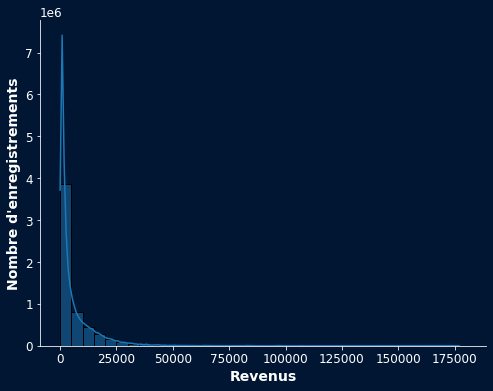

In [79]:
# Visualisation de la distribution
plt.figure(figsize=(8, 6))

sns.histplot(data=data,
             x='y_child',
             kde=True,
             binwidth=5000)

sns.despine()

plt.xlabel("Revenus")
plt.ylabel("Nombre d'enregistrements")

plt.savefig(save + r'\09_distrib_income', bbox_inches='tight')

plt.show()

In [80]:
# Test de Kolmogorov-Smirnov
gauss = np.random.normal(loc=data['y_child'].mean(),
                         scale=data['y_child'].std(ddof=0),
                         size=len(data))
F, p = stats.ks_2samp(data['y_child'], gauss)
del gauss  # Libération de la mémoire

print('Résultat du test de Kolmogorov-Smirnov')
print(f'- Statistique de test : {F}, p_value : {p}')
if p < alpha:
    print("- H0 rejettée, Distribution probablement non Gaussienne")
else:
    print("- H0 validée, Distribution probablement Gaussienne")

Résultat du test de Kolmogorov-Smirnov
- Statistique de test : 0.2633893103448276, p_value : 0.0
- H0 rejettée, Distribution probablement non Gaussienne


L'allure de la courbe de la distribution est fortement déviée. Le test va égelement dans ce sens et réfute l'hypothèse de normalité. <br>
Bien que notre échantillon soit de grande taille, l'hypothèse de normalité est ici invalidée.

Pour compléter nos observations, un boxplot des revenus par pays est réalisé ci-dessous.

**Homoscédasticité**

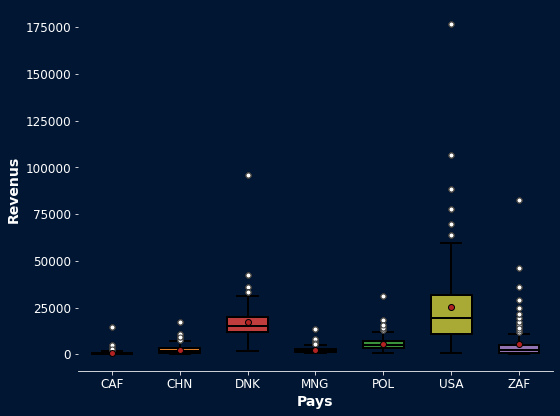

In [81]:
# Vérification de l'homoscédasticité
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(data=subset,
            x='code_iso3',
            y='y_child',
            order=select,
            palette=tableau10,
            width=0.6,
            linewidth=2.,
            showmeans=True,
            showfliers=True,
            **props)

# Modifications des axes
sns.despine(left=True)
plt.xlabel('Pays')
plt.ylabel('Revenus')
plt.tight_layout()

plt.savefig(save + r'\10_box_anova_income', bbox_inches='tight')

plt.show()

Nouv voyons nettement ici que l'hypothèse d'homoscédasticité n'est pas vérifiée. Les plages de valeurs des différents affichés ne sont pas du même ordre.

Les hypothèses étant invalidées nous réalisons un test de Kruskal-Wallis afin de vérifier que nous retrouvons bien les différences visibles sur le boxplot. <br>
Il est important de noter que ce test porte sur les médianes et non les moyennes mais la formulation reste la même que pour l'ANOVA, à savoir que toutes les médianes doivent être équivalentes pour valider l'hypothèse nulle $H_0$.

In [82]:
# Test de Kruskal-Wallis
H, p = stats.kruskal(*inc_groups)

print('Résultat du test de Kruskal-Wallis')
print(f'- Statistique de test : {H}, p_value : {p}')
if p < alpha:
    print("- H0 rejettée, Médianes non équivalentes")
else:
    print("- H0 validée, Médianes équivalentes")

Résultat du test de Kruskal-Wallis
- Statistique de test : 4860371.921227203, p_value : 0.0
- H0 rejettée, Médianes non équivalentes


Le test nous indique que nous avons une différence significative entre les médianes des différents pays (p < 0.05).

Bien que les hypothèses ne soient pas validées, nous allons réaliser une ANOVA pour voir si nous retrouvons bien un résultat semblable au test de Kruskal-Wallis.

In [83]:
data['y_child'][data['code_iso3'] == 'ALB']

0         1351.312256
1          916.662354
2         1351.312256
3          728.897949
4          916.662354
             ...     
49995     6231.099609
49996    17754.324219
49997    17754.324219
49998    17754.324219
49999    17754.324219
Name: y_child, Length: 50000, dtype: float32

In [84]:
stats.f_oneway(*inc_groups)

F_onewayResult(statistic=192.0043038470101, pvalue=0.0)

In [85]:
# Création du modèle logarithmique
model = smf.ols('y_child ~ code_iso3', data=data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
code_iso3,2.551188e+14,115.0,2.218424e+12,49710.758978,0.0,0.49639,0.49638
Residual,2.588293e+14,5799884.0,4.462664e+07,NaN,NaN,NaN,NaN


In [86]:
del model  # Libération de la mémoire

**Conclusion**

Le test et l'ANOVA nous indique que nous avons une différence significative entre les médianes et moyennes (respectivement) des différents pays (p < 0.05). <br>
Nous obtenons un résultat attendu : le pays d'origine a bien une influence sur la distribution des revenus. Cette différence est déjà visible sans test à partir des graphiques ci-dessus. De plus la variance expliquée par le modèle est faible ($R^2 = 0.5$).

Maintenant nous allons procéder de la même manière en utilisant une transformation logarithmique de la variable dépendante pour observer la différence avec le cas précédent.

#### Revenus log

Utilisation du logarithme néperien de la variable $ln(y_{\large child})$

**Normalité**

Nous commençons par analyser la normalité de notre échantillon.

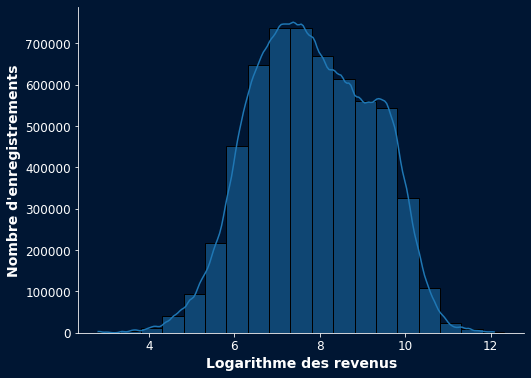

In [87]:
# Visualisation de la distribution
plt.figure(figsize=(8, 6))

sns.histplot(data=data,
             x='ln_y_child',
             kde=True,
             binwidth=0.5)

sns.despine()

plt.xlabel("Logarithme des revenus")
plt.ylabel("Nombre d'enregistrements")

plt.savefig(save + r'\11_distrib_log_income', bbox_inches='tight')

plt.show()

In [88]:
# Test de Kolmogorov-Smirnov
gauss_ln = np.random.normal(loc=data['ln_y_child'].mean(),
                            scale=data['ln_y_child'].std(ddof=0),
                            size=len(data))
F, p = stats.ks_2samp(data['ln_y_child'], gauss_ln)
del gauss_ln  # Libération de la mémoire

print('Résultat du test de Kolmogorov-Smirnov')
print(f'- Statistique de test : {F}, p_value : {p}')
if p < alpha:
    print("- H0 rejettée, Distribution probablement pas Gaussienne")
else:
    print("- H0 validée, Distribution probablement Gaussienne")

Résultat du test de Kolmogorov-Smirnov
- Statistique de test : 0.035933620689655166, p_value : 0.0
- H0 rejettée, Distribution probablement pas Gaussienne


Le test rejette l'hypothèse de normalité. Ce constat était prévisible car la distribution est bimodale d'après le graphique précédent. Néanmoins, nous ne pouvons ignorer la nette amélioration de la distribution. <br>
Dans ce cas nous allons utiliser le théorème central limite qui nous dit que pour un grand nombre d'observation, la distribution tend vers une distribution normale.

Ainsi nous poursuivons la vérification des hypothèses par un test paramétrique de Levene pour vérifier l'homoscédasticité.

**Homoscédasticité**

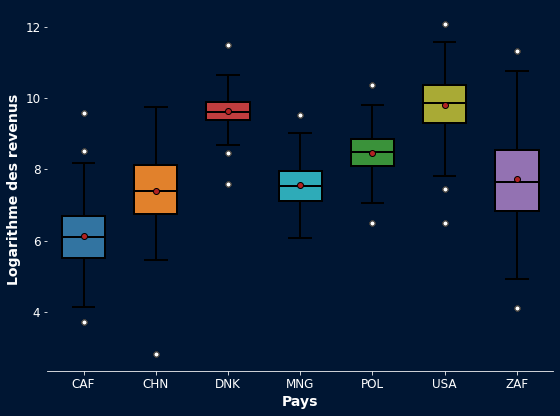

In [89]:
# Vérification de l'homoscédasticité
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(data=subset,
            x='code_iso3',
            y='ln_y_child',
            order=select,
            palette=tableau10,
            width=0.6,
            linewidth=2.,
            showmeans=True,
            showfliers=True,
            **props)

# Modifications des axes
sns.despine(left=True)
plt.xlabel('Pays')
plt.ylabel('Logarithme des revenus')
plt.tight_layout()

plt.savefig(save + r'\12_box_anova_log_income', bbox_inches='tight')

plt.show()

In [90]:
# Test de Levene
F, p = stats.levene(*log_inc_groups, center='mean')

print('Résultat du test de Levene')
print(f'- Statistique de test : {F}, p_value : {p}')
if p < alpha:
    print("- H0 rejettée, Variances non équivalentes")
else:
    print("- H0 validée, Variances équivalentes")

Résultat du test de Levene
- Statistique de test : 10.595919723775264, p_value : 0.0
- H0 rejettée, Variances non équivalentes


Comme pour la normalité, le résultat est nettement meilleur. Cependant, le graphique comme le test rejette l'hypothèse d'homoscédasticité. Les différences de variances sont bien visibles. <br>

Les hypothèses étant invalidées nous réalisons un test de Kruskal-Wallis afin de vérifier que nous ayons bien une différence significative entre les médianes. <br>

In [91]:
# Test de Kruskal-Wallis
H, p = stats.kruskal(*log_inc_groups)

print('Résultat du test de Kruskal-Wallis')
print(f'- Statistique de test : {H}, p_value : {p}')
if p < alpha:
    print("- H0 rejettée, Médianes non équivalentes")
else:
    print("- H0 validée, Médianes équivalentes")

Résultat du test de Kruskal-Wallis
- Statistique de test : 4860371.938572277, p_value : 0.0
- H0 rejettée, Médianes non équivalentes


Le test nous indique que nous avons une différence significative entre les médianes des différents pays (p < 0.05).

Comme précédemment, bien que les hypothèses ne soient pas validées, nous réalisons une ANOVA pour la comparer au test précédent ainsi qu'au résultat obtenu avec les revenus non transformés.

In [92]:
# Création du modèle logarithmique
model_ln = smf.ols('ln_y_child ~ code_iso3', data=data).fit()
aov_table = sm.stats.anova_lm(model_ln, typ=2)
anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
code_iso3,8.067209e+06,115.0,70149.642775,135832.37451,0.0,0.729238,0.729233
Residual,2.995308e+06,5799884.0,0.516443,NaN,NaN,NaN,NaN


In [93]:
del model_ln  # Libération de la mémoire

**Conclusion**

L'ANOVA nous indique encore une fois que les moyennes des différents pays sont différentes (PR < 0.05). La variance expliquée de ce modèle est toute fois bien meilleure (0.73 en log contre 0.50 en non-log).

Le résultat ne correspond pas non plus à une distribution gaussienne bien que la transformation ait nettement amélioré la distribution.

Le boxplot et le test de Levene nous montre que les groupes ont des variances sensiblement différentes.

L'ANOVA est relativement robuste car nous avons des sous-groupes de tailles identiques (50 000 enregistrements par groupe) et un grand nombre de données (5 800 000 individus).

Ces tests nous permettent de voir qu'il y a des différence entre les groupes. Nous retiendront également que le modèle logarithmique donne de meilleurs résultats. Le seul point à garder en tête pour interpréter ce modèle c'est qu'il faut appliquer la transformation inverse pour revenir aux données d'origines. En effet, interpréter les résultats transfomés peut conduire à une analyse erronée.

### Régressions linéaire

Nous souhaitons maintenant comprendre quels facteurs permettent d'expliquer les revenus des enfants.

Avant d'effectuer les régressions, nous allons vérifier la normalité des grandeurs utilisées de la même façon que pour l'ANOVA (graphique + test).

#### Hypothèse de normalité

- **Normalité** : à vérifier pour les variables indépendantes $\rightarrow$ **gdpppp**, **gini** et **ln_gdpppp** et les résidus de la régression.

Les variables mentionnées ci-dessus sont les mêmes pour un pays donné (un unique indice de gini et gdppppp par pays). La normalité ne sera testée en ne considérant qu'une valeur par pays (sans tenir compte des doublons).

Ici, la normalité n'est pas nécessaire pour le fonctionnement de la régression. Néanmoins, des variables dont la distribution dévie fortement d'une distribution normale peut influencer la régression. Elle sera, en revanche, systématiquement vérifiée sur les résidus.

In [94]:
subset = data[['code_iso3', 'gdpppp', 'gini', 'ln_gdpppp']].drop_duplicates()
subset = subset.reset_index(drop=True)
subset.head(5)

,code_iso3,gdpppp,gini,ln_gdpppp
0,ALB,7297.0,30.462429,8.895219
1,ARG,13220.0,44.990166,9.489486
2,ARM,5611.0,26.310762,8.632484
3,AUT,36193.0,27.827911,10.496621
4,AZE,8101.0,31.232119,8.999743


**Vérification graphique**

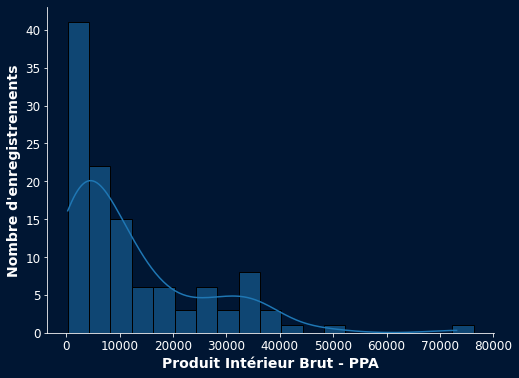

In [95]:
# Visualisation de la distribution
plt.figure(figsize=(8, 6))

sns.histplot(data=subset,
             x='gdpppp',
             kde=True,
             binwidth=4000)

sns.despine()

plt.xlabel('Produit Intérieur Brut - PPA')
plt.ylabel("Nombre d'enregistrements")

plt.savefig(save + r'\13_distrib_gdpppp', bbox_inches='tight')

plt.show()

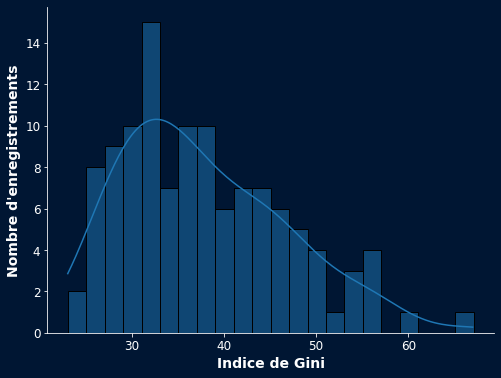

In [96]:
# Visualisation de la distribution
plt.figure(figsize=(8, 6))

sns.histplot(data=subset,
             x='gini',
             kde=True,
             binwidth=2)

sns.despine()

plt.xlabel('Indice de Gini')
plt.ylabel("Nombre d'enregistrements")

plt.savefig(save + r'\14_distrib_gini', bbox_inches='tight')

plt.show()

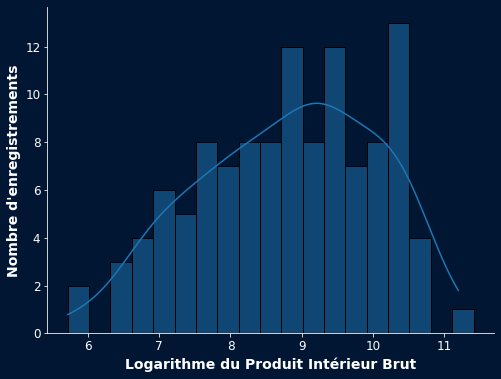

In [97]:
# Visualisation de la distribution
plt.figure(figsize=(8, 6))

sns.histplot(data=subset,
             x='ln_gdpppp',
             kde=True,
             binwidth=0.3)

sns.despine()

plt.xlabel('Logarithme du Produit Intérieur Brut')
plt.ylabel("Nombre d'enregistrements")

plt.savefig(save + r'\15_distrib_log_gdpppp', bbox_inches='tight')

plt.show()

**Test de Shapiro-Wilk**

In [98]:
# Test de Shapiro-Wilk
F, p = stats.shapiro(subset['gdpppp'])

print('Résultat du test de Shapiro-Wilk')
print(f'- Statistique de test : {F}, p_value : {p}')
if p < alpha:
    print('- H0 rejettée, Distribution probablement non Gaussienne')
else:
    print('- H0 validée, Distribution probablement Gaussienne')

Résultat du test de Shapiro-Wilk
- Statistique de test : 0.811671257019043, p_value : 7.042445099303407e-11
- H0 rejettée, Distribution probablement non Gaussienne


In [99]:
# Test de Shapiro-Wilk
F, p = stats.shapiro(subset['gini'])

print('Résultat du test de Shapiro-Wilk')
print(f'- Statistique de test : {F}, p_value : {p}')
if p < alpha:
    print('- H0 rejettée, Distribution probablement non Gaussienne')
else:
    print('- H0 validée, Distribution probablement Gaussienne')

Résultat du test de Shapiro-Wilk
- Statistique de test : 0.9544247984886169, p_value : 0.0005934455548413098
- H0 rejettée, Distribution probablement non Gaussienne


In [100]:
# Test de Shapiro-Wilk
F, p = stats.shapiro(subset['ln_gdpppp'])

print('Résultat du test de Shapiro-Wilk')
print(f'- Statistique de test : {F}, p_value : {p}')
if p < alpha:
    print('- H0 rejettée, Distribution probablement non Gaussienne')
else:
    print('- H0 validée, Distribution probablement Gaussienne')

Résultat du test de Shapiro-Wilk
- Statistique de test : 0.9727055430412292, p_value : 0.01806362345814705
- H0 rejettée, Distribution probablement non Gaussienne


La variable $gdpppp$ dévie fortement. Sa transformation en logarithme permet de retrouver une distribution plus proche d'une loi normale comme pour la variable dépendante $y_{\large child}$. Nous verrons en comparant les différents modèles si la transformation logarithmique donne un meilleur résultat.

Nous allons maintenant comparer 3 régressions différentes. Pour chaque régression nous vérifierons la potentielle colinéarité des variables indépendantes (problème qui peut dégrader le résultat de la régression) ainsi que la normalité des résidus.

La collinéarité peut être testée avec le coefficient **VIF** (**V**ariance **I**nflation **F**actor). Si ce coefficient est supérieur à 2 pour au moins une des variables, cela peut mettre en évidence un problème de colinéarité des variables indépendantes (i.e. au moins deux variables expliquent les mêmes variations).

#### Modèle $\large y_{child}$  $= f(gdpppp + gini)$

In [101]:
reg_1 = smf.ols('y_child ~ gdpppp + gini', data=data).fit()
print(reg_1.summary())

                            OLS Regression Results                            
Dep. Variable:                y_child   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                 2.351e+06
Date:                Sun, 17 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:55:01   Log-Likelihood:            -5.9578e+07
No. Observations:             5800000   AIC:                         1.192e+08
Df Residuals:                 5799997   BIC:                         1.192e+08
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -648.9088     15.138    -42.866      0.0

**Colinéarité / Stabilité**

In [102]:
# Crétation de la matrice de conception utilisée par Statsmodels
x = patsy.dmatrix('gdpppp + gini', data=data)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x, i)
                     for i in range(x.shape[1])]
vif["Features"] = x.design_info.term_names

vif

,VIF Factor,Features
0,27.157933,Intercept
1,1.185630,gdpppp
2,1.185630,gini


Les deux variables indépendantes semblent bien non colinéaires. Cependant, le sommaire de Statsmodels renvoi un nombre de conditionnement (Cond. No.) élevé. Ceci signifie que la matrice de conception (design matrix) n'est pas bien conditionnée. Nous n'allons pas essayer de régler ce problème ici mais nous gardons en tête ce résultat pour le comparer avec les régressions suivantes.

**Normalité des résidus**

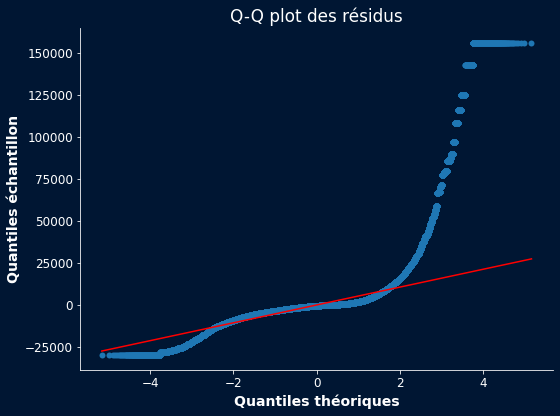

In [103]:
fig, ax = plt.subplots(figsize=(8, 6))

normality_plot, stat = stats.probplot(reg_1.resid, plot=plt, rvalue=False)
ax.set_title('Q-Q plot des résidus')
ax.get_lines()[0].set_markerfacecolor('#1f77b4')
ax.get_lines()[0].set_markeredgecolor('None')
plt.xlabel('Quantiles théoriques')
plt.ylabel('Quantiles échantillon')

sns.despine()
plt.tight_layout()

plt.savefig(save + r'\16_qqplot_resid_reg_1', bbox_inches='tight')

plt.show()

Les tests de normalités sur les résidus sont réalisés par Statsmodels. Ceux-ci correspondent aux tests Omnibus et Jarque-Bera pour lesquels nous avons la statistique du test ainsi que la p-value associées (prob()). Les tests rejettent l'hypothèse de normalité mais le graphique permet de mieux comprendre d'où vient le problème.

Comme nous pouvions nous y attendre, les queues de distribution sont fortement déviées. Ce problème est sûrement lié aux distrubtions de la variable dépendante et de $gdpppp$.

En regardant plus en détail le résumé de Statsmodels, nous pouvons voir que les coefficients des variables sont tous significatifs ($P>|t|$ inférieur au seuil $\alpha = 0.05$). Le modèle permet d'expliquer environ 45% de la variance totale ($R^2 = 0.448$). Le reste de la variance n'est donc pas prise en compte par ce modèle.

Regardons maintenant l'effet de la transformation logarithmique de ces deux variables sur le modèle.

#### Modèle $ln(y_{\large child})$  $= f(ln(gdpppp) + gini)$

In [104]:
reg_2 = smf.ols('ln_y_child ~ ln_gdpppp + gini', data=data).fit()
print(reg_2.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_y_child   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                 5.432e+06
Date:                Sun, 17 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:55:36   Log-Likelihood:            -7.0418e+06
No. Observations:             5800000   AIC:                         1.408e+07
Df Residuals:                 5799997   BIC:                         1.408e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7874      0.003    237.657      0.0

In [105]:
# Crétation de la matrice de conception utilisée par Statsmodels
x = patsy.dmatrix('ln_gdpppp + gini', data=data)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x, i)
                     for i in range(x.shape[1])]
vif["Features"] = x.design_info.term_names

vif

,VIF Factor,Features
0,95.914863,Intercept
1,1.095312,ln_gdpppp
2,1.095312,gini


Les deux variables indépendantes semblent également non colinéaires. Le nombre de conditionnement (Cond. No.) est nettement plus faible cette fois-ci.

**Normalité des résidus**

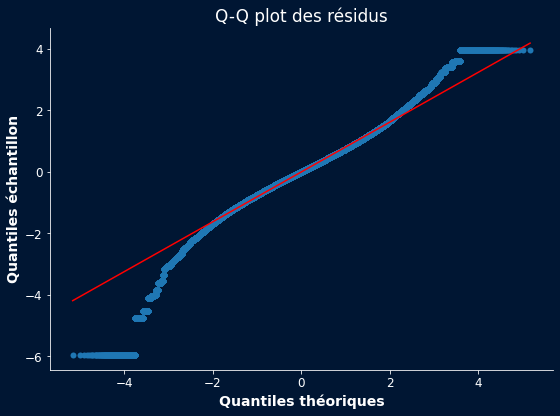

In [106]:
fig, ax = plt.subplots(figsize=(8, 6))

normality_plot, stat = stats.probplot(reg_2.resid, plot=plt, rvalue=False)
ax.set_title('Q-Q plot des résidus')
ax.get_lines()[0].set_markerfacecolor('#1f77b4')
ax.get_lines()[0].set_markeredgecolor('None')
plt.xlabel('Quantiles théoriques')
plt.ylabel('Quantiles échantillon')

sns.despine()
plt.tight_layout()

plt.savefig(save + r'\17_qqplot_resid_reg_2', bbox_inches='tight')

plt.show()

Les tests rejettent également l'hypothèse de normalité. Cette fois-ci, les résidus suivent une distribution beaucoup plus proche d'une distribution normale. Les queues sont encore légèrement déviées mais le problème observé avec le cas précédent n'est plus aussi impactant.

En regardant plus en détail le résumé de Statsmodels, nous pouvons voir que les coefficients des variables sont tous significatifs ($P>|t|$ inférieur au seuil $\alpha = 0.05$). Le modèle permet d'expliquer environ 65% de la variance totale ($R^2 = 0.652$). Ce résultat est en nette progression.

Regardons maintenant l'effet de l'ajout de la classe de revenu des parents sur la variance expliquée par ce modèle logarithmique.

#### Modèle $ln(y_{\large child})$  $= f(ln(gdpppp) + gini + c_{\large i,~parent})$

In [107]:
reg_3 = smf.ols('ln_y_child ~ ln_gdpppp + gini + c_i_parent', data=data).fit()
print(reg_3.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_y_child   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                 5.234e+06
Date:                Sun, 17 Oct 2021   Prob (F-statistic):               0.00
Time:                        22:56:10   Log-Likelihood:            -6.3027e+06
No. Observations:             5800000   AIC:                         1.261e+07
Df Residuals:                 5799996   BIC:                         1.261e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1113      0.003     37.574      0.0

In [108]:
# Crétation de la matrice de conception utilisée par Statsmodels
x = patsy.dmatrix('ln_gdpppp + gini + c_i_parent', data=data)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x, i)
                     for i in range(x.shape[1])]
vif["Features"] = x.design_info.term_names

vif

,VIF Factor,Features
0,98.975469,Intercept
1,1.095312,ln_gdpppp
2,1.095312,gini
3,1.000000,c_i_parent


Les deux variables indépendantes semblent également non colinéaires. Le nombre de conditionnement (Cond. No.) est un peu  plus élevé que le modèle précédent ce qui s'explique par l'introduction d'une nouvelle variable.

**Normalité des résidus**

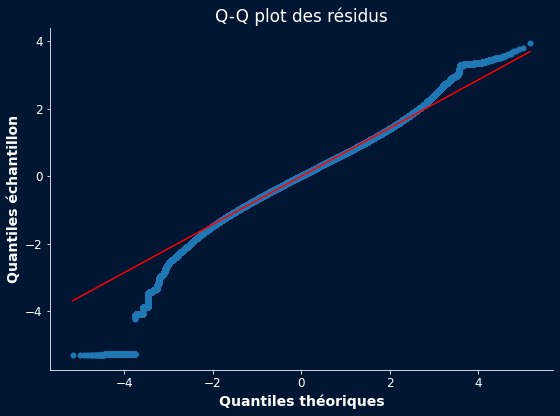

In [109]:
fig, ax = plt.subplots(figsize=(8, 6))

normality_plot, stat = stats.probplot(reg_3.resid, plot=plt, rvalue=False)
ax.set_title('Q-Q plot des résidus')
ax.get_lines()[0].set_markerfacecolor('#1f77b4')
ax.get_lines()[0].set_markeredgecolor('None')
plt.xlabel('Quantiles théoriques')
plt.ylabel('Quantiles échantillon')

sns.despine()
plt.tight_layout()

plt.savefig(save + r'\18_qqplot_resid_reg_3', bbox_inches='tight')

plt.show()

Les tests rejettent également l'hypothèse de normalité. Les résidus suivent une distribution similaire au cas précédent bien que l'erreur est sensiblement réduite pour les revenus les plus élevés.

En regardant plus en détail le résumé de Statsmodels, nous pouvons voir que les coefficients des variables sont tous significatifs ($P>|t|$ inférieur au seuil $\alpha = 0.05$). Le modèle permet d'expliquer environ 73% de la variance totale ($R^2 = 0.730$). L'ajout de la variable $c_{\large i, parent}$ permet donc ici d'améliorer significatement le modèle.

**Conclusion**

La régression comprenant les variables logarithmiques et la classe de revenu des parents fourni le meilleur résultat. Les résidus suivent en grande partie une loi normale (sauf pour les revenus les plus faibles) et il n'y a pas de problème de colinéarité évident. Ce modèle n'est pas parfait. Il pourrait encore être amélioré en supprimant des pays dont les individus sont atypiques et influents (valeurs anormalement éloignées du reste de la distribution qui ont un "effet" de levier important).

Pour terminer, nous allons analyser un peu plus en détail les résidus de la dernière régression.

#### Analyse des résidus

Pour commencer observons la distribution des résidus.

**Distribution des résidus**

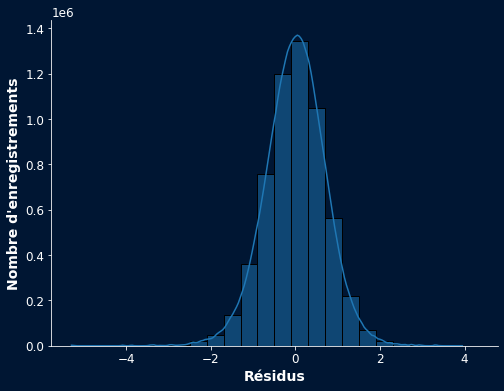

In [110]:
# Visualisation de la distribution
plt.figure(figsize=(8, 6))

sns.histplot(data=reg_3.resid,
             kde=True,
             binwidth=0.4)

sns.despine()

plt.xlabel("Résidus")
plt.ylabel("Nombre d'enregistrements")

plt.savefig(save + r'\19_distrib_residus', bbox_inches='tight')

plt.show()

La distribution n'est pas très loin d'une loi normale bien que les tests ont rejettés cette hypothèse. <br>
Cette observation ainsi que la taille de l'échantillon ($n >> 30$) permettent de dire que les résultats obtenus par le modèle linéaire guassien ne sont pas absurdes.

Analysons maintenant les valeurs atypiques de notre jeu de données.

**Valeurs atypiques**

In [111]:
n = len(data)  # Nombre d'individus
p = 3  # Nombre de variables explicatives

%pycodestyle_off

# Table contenant les mesures
analyse = pd.DataFrame({'obs':np.arange(1, n+1)})
analyse['levier'] = reg_3.get_influence().hat_matrix_diag
analyse['rstudent'] = reg_3.get_influence().resid_studentized_internal

%pycodestyle_on

# Calcul des seuils
seuil_levier = 2 * p / n
seuil_rstudent = stats.t.ppf(1-alpha/2, n-p-1)

# Index des valeurs atypiques (variables exogènes)
index_levier = analyse.loc[analyse['levier'] > seuil_levier, :].index

# Index des valeurs atypiques (variable endogène)
index_rstudent = analyse.loc[(analyse['rstudent'] > seuil_rstudent) |
                             (analyse['rstudent'] < -seuil_rstudent), :].index

In [112]:
# Pourcentages des observations concernées
df_levier = data.loc[index_levier, :]
_ = len(df_levier) / n * 100
print('Pourcentage de valeurs atypiques (exogènes) : {:0.2f}'.format(_), '%')

df_rstudent = data.loc[index_rstudent, :]
_ = len(df_rstudent) / n * 100
print('Pourcentage de valeurs atypiques (endogène) : {:0.2f}'.format(_), '%')

Pourcentage de valeurs atypiques (exogènes) : 11.71 %
Pourcentage de valeurs atypiques (endogène) : 5.12 %


In [113]:
# Top 10 des pays par pourcentage de valeurs atypiques (exogènes)
df = (df_levier['code_iso3'].value_counts() / 50000 * 100).head(10)
index = df.index
df = df.reset_index().rename(columns={'code_iso3': 'value (%)',
                                      'index': 'code_iso3'})
df['value (%)'] = df['value (%)'].round(0).astype('uint8')

df = df.merge(countries, how='left', on='code_iso3')
df = df[['code_iso3', 'country', 'value (%)']]
df

,code_iso3,country,value (%)
0,ZAF,South Africa,100
1,LBR,Liberia,100
2,COD,"Congo, Dem. Rep.",100
3,HND,Honduras,100
4,CAF,Central African Republic,100
5,COL,Colombia,100
6,GTM,Guatemala,62
7,BRA,Brazil,48
8,CHL,Chile,48
9,BOL,Bolivia,48


In [114]:
# Top 10 des pays par pourcentage de valeurs atypiques (endogène)
df = (df_rstudent['code_iso3'].value_counts() / 50000 * 100).head(10)
index = df.index
df = df.reset_index().rename(columns={'code_iso3': 'value (%)',
                                      'index': 'code_iso3'})
df['value (%)'] = df['value (%)'].round(0).astype('uint8')

df = df.merge(countries, how='left', on='code_iso3')
df = df[['code_iso3', 'country', 'value (%)']]
df

,code_iso3,country,value (%)
0,SWZ,Eswatini,58
1,SYR,Syrian Arab Republic,37
2,ZAF,South Africa,17
3,CIV,Cote d'Ivoire,17
4,HND,Honduras,16
5,LBR,Liberia,15
6,BOL,Bolivia,14
7,NIC,Nicaragua,13
8,CAF,Central African Republic,12
9,MEX,Mexico,11


La majorité des valeurs atypiques semblent provenir de pays fortement inégalitaires.

Pour vérifier que les valeurs atypiques ne soient pas problématique pour le modèle il faut quantifier leur **influence**. Une méthode classique est de calculer la **distance de Cook** pour chaque observation. Si cette distance dépasse une valeur seuil, les observations concernées peuvent être considérées comme influentes. <br>
Les individus à retirer sont ceux qui sont qualifiés d'**atypique et influent**. Ces valeurs représentent des cas particuliers qui dégradent le résultat de la régression. En supprimant ces individus nous pourrions obtenir une régression qui explique une part plus importante des variations de la variable endogène.

Ici, nous ne calculerons pas la distance de Cook pour des raisons de performance (temps de calcul très long à partir des résultats de Statsmodels).